In [1]:
import sys
import os
import uproot
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter

from functools import partial

In [2]:
### Import functions from peak_functions

repository_path = os.path.abspath('../..')
sys.path.append(repository_path)

import blr_functions  as blr
import peak_functions as pf
import fit_functions  as fitf

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
plt.rcParams["figure.figsize"] = 8, 5
plt.rcParams["font.size"]      = 11

In [5]:
filename = '/Users/romoluque_c/LEGEND/BACON/datatest/run-11_20_2023-file_1.root'
infile   = uproot.open(filename)
RawTree  = infile['RawTree']

## Trigger SiPMs

In [6]:
max_smpl_bsl        = 650
thr_ADC             = 50
sg_filter_window    = 50
sg_filter_polyorder = 3

trigger_chs = [9, 10, 11]

trigg_cwfs_dict = {ch: np.array([blr.pmt_deconvolver(wf, wf_range_bsl=(0, max_smpl_bsl))
                                 for wf in pf.wfs_from_rawtree(RawTree, ch)])
                   for ch in trigger_chs}

sg_filt_trigg_dict = {ch: savgol_filter(trigg_cwfs_dict[ch],
                                        window_length=sg_filter_window,
                                        polyorder=sg_filter_polyorder)
                      for ch in trigger_chs}

zs_sg_filt_trigg_dict = {ch: pf.noise_suppression(sg_filt_trigg_dict[ch],
                                                  threshold=thr_ADC)
                         for ch in trigger_chs}

partial_get_peaks_peakutils = partial(pf.get_peaks_peakutils, thres=thr_ADC, min_dist=100, thres_abs=True)
idx_peaks_ch_trigg_dict = {ch: np.array(list(map(partial_get_peaks_peakutils, zs_sg_filt_trigg_dict[ch])), dtype=object)
                           for ch in trigger_chs}

#idx_peaks_ch_trigg_dict = {ch: np.array(list(map(pf.get_peaks_peakutils, zs_sg_filt_trigg_dict[ch])), dtype=object)
#                           for ch in trigger_chs}

height_peaks_ch_trigg_dict = {ch: np.array([pf.peak_height(wf, idx_peaks_ch_trigg_dict[ch][i])
                                            for i,wf in enumerate(zs_sg_filt_trigg_dict[ch])], dtype=object)
                              for ch in trigger_chs}

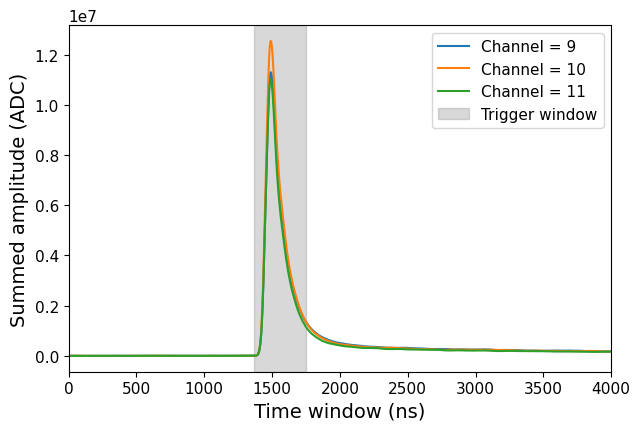

In [7]:
plt.figure(figsize=(7, 4.5))
for ch in trigger_chs:
    sum_wf = np.sum(trigg_cwfs_dict[ch], axis=0)
    plt.plot(2*np.arange(len(sum_wf)), sum_wf, label=f'Channel = {ch}')
plt.axvspan(1370, 1750, color='grey', alpha=0.3, label='Trigger window')
plt.xlabel('Time window (ns)',       fontsize=14)
plt.ylabel('Summed amplitude (ADC)', fontsize=14)
plt.legend()
plt.xlim(0,4000)
plt.show()

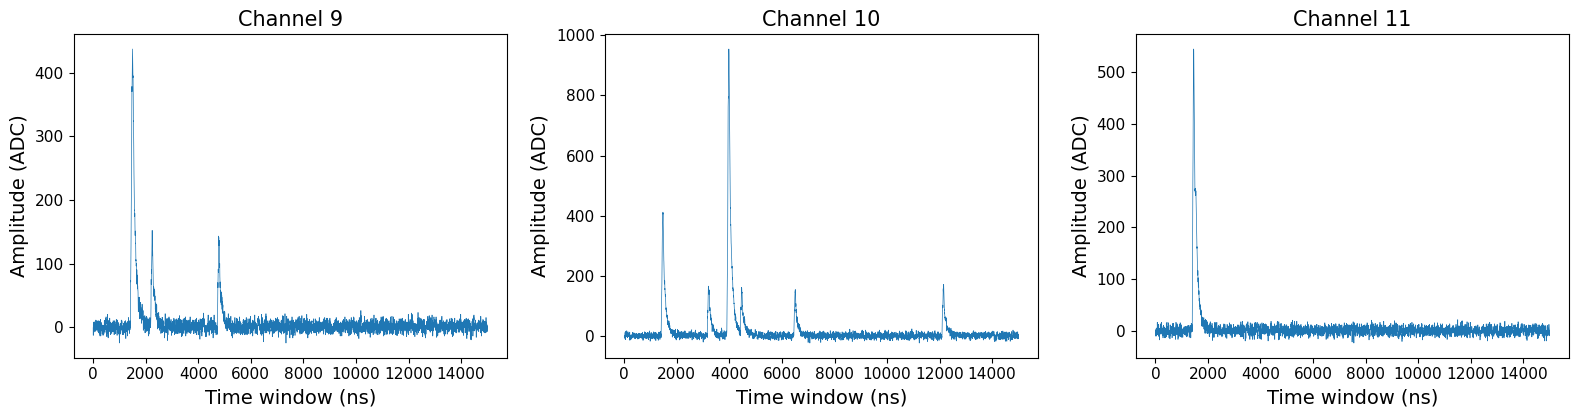

In [8]:
sel_evt  = 0
fig, axs = plt.subplots(1, 3, figsize=(16, 4.3))
for k, ch in enumerate(trigger_chs):
    j = k%3
    sel_wf = trigg_cwfs_dict[ch][sel_evt]
    axs[j].plot(2*np.arange(len(sel_wf)), sel_wf, linewidth=0.5)
    axs[j].set_xlabel('Time window (ns)', fontsize=14)
    axs[j].set_ylabel('Amplitude (ADC)', fontsize=14)
    axs[j].set_title(f"Channel {ch}", fontsize=15)
plt.tight_layout()
plt.show()

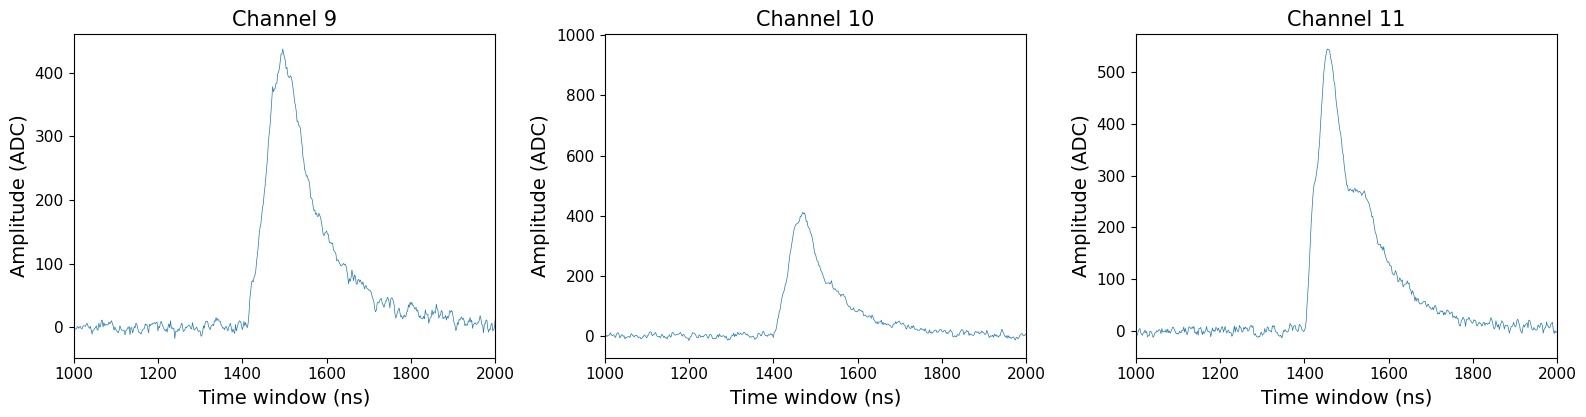

In [9]:
sel_evt  = 0
fig, axs = plt.subplots(1, 3, figsize=(16, 4.3))
for k, ch in enumerate(trigger_chs):
    j = k%3
    sel_wf = trigg_cwfs_dict[ch][sel_evt]
    axs[j].plot(2*np.arange(len(sel_wf)), sel_wf, linewidth=0.5)
    axs[j].set_xlabel('Time window (ns)', fontsize=14)
    axs[j].set_ylabel('Amplitude (ADC)', fontsize=14)
    axs[j].set_title(f"Channel {ch}", fontsize=15)
    axs[j].set_xlim(1000, 2000)
plt.tight_layout()
plt.show()

-------------------------- Evt = 0 --------------------------


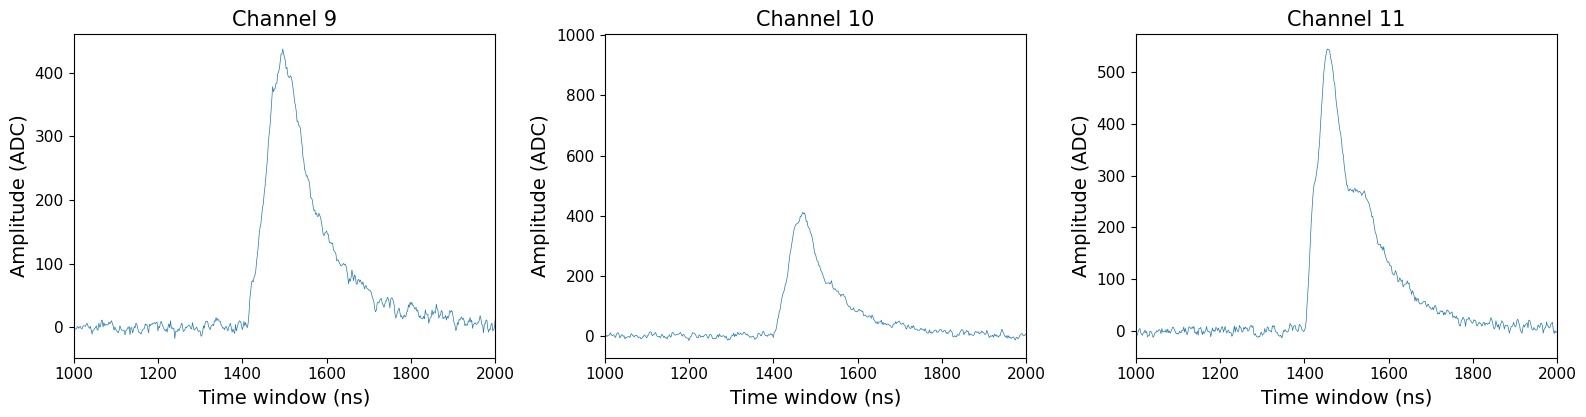

-------------------------- Evt = 1 --------------------------


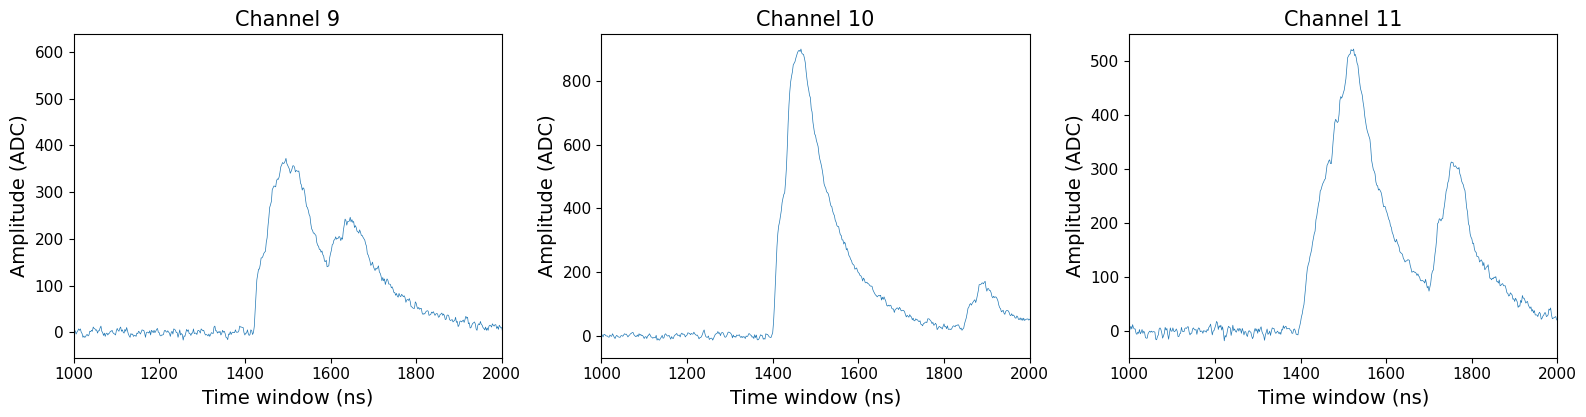

-------------------------- Evt = 2 --------------------------


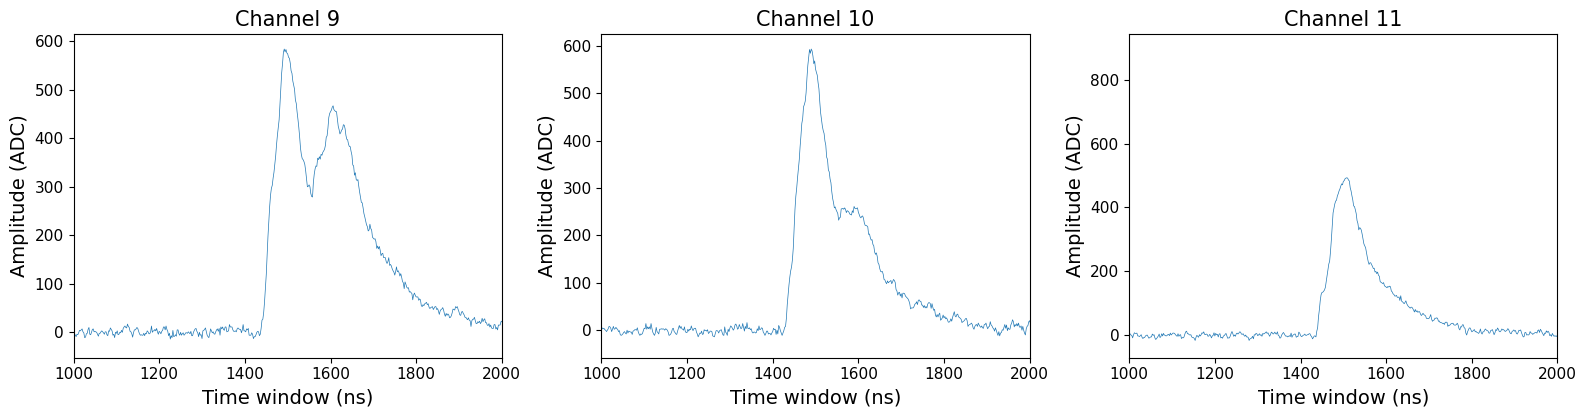

-------------------------- Evt = 3 --------------------------


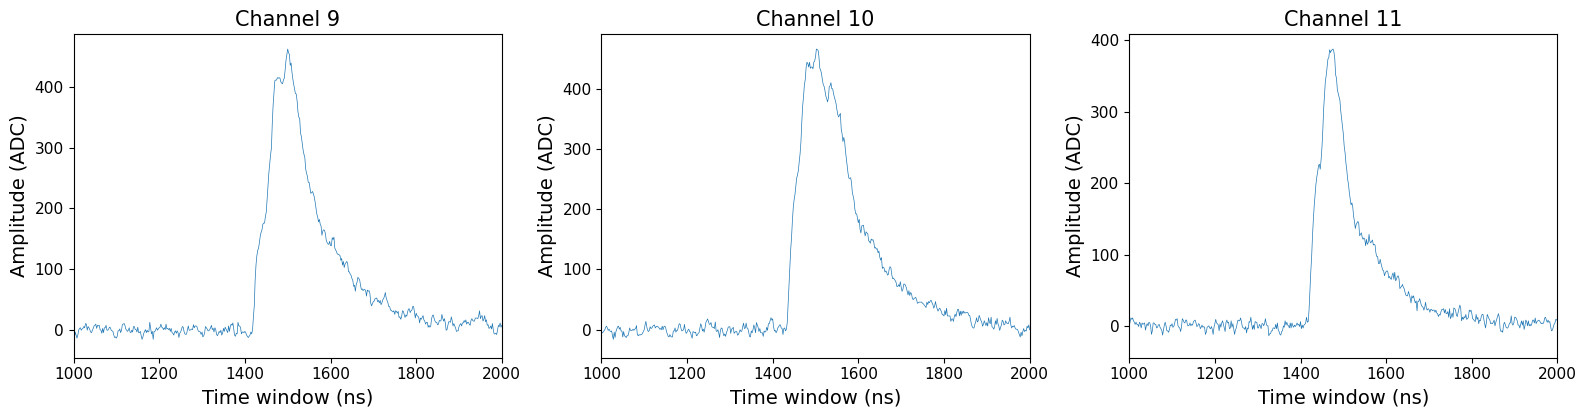

-------------------------- Evt = 4 --------------------------


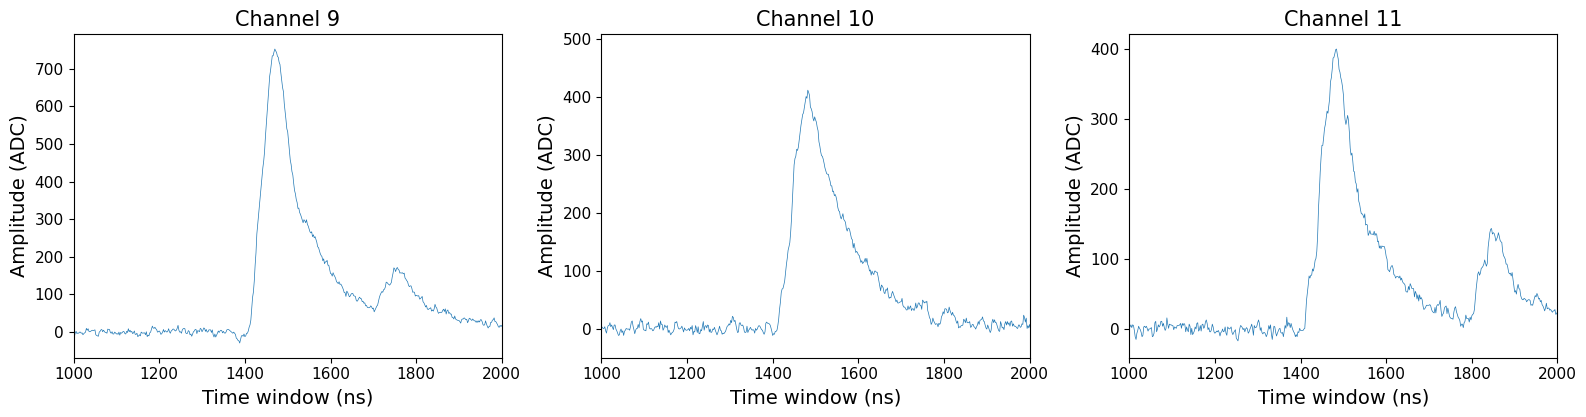

-------------------------- Evt = 5 --------------------------


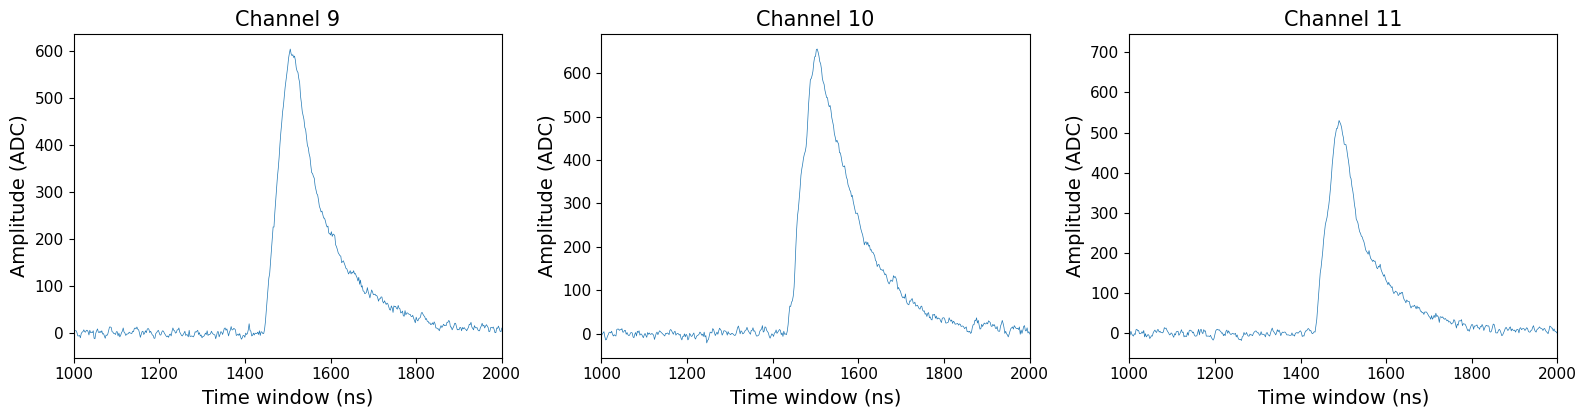

-------------------------- Evt = 6 --------------------------


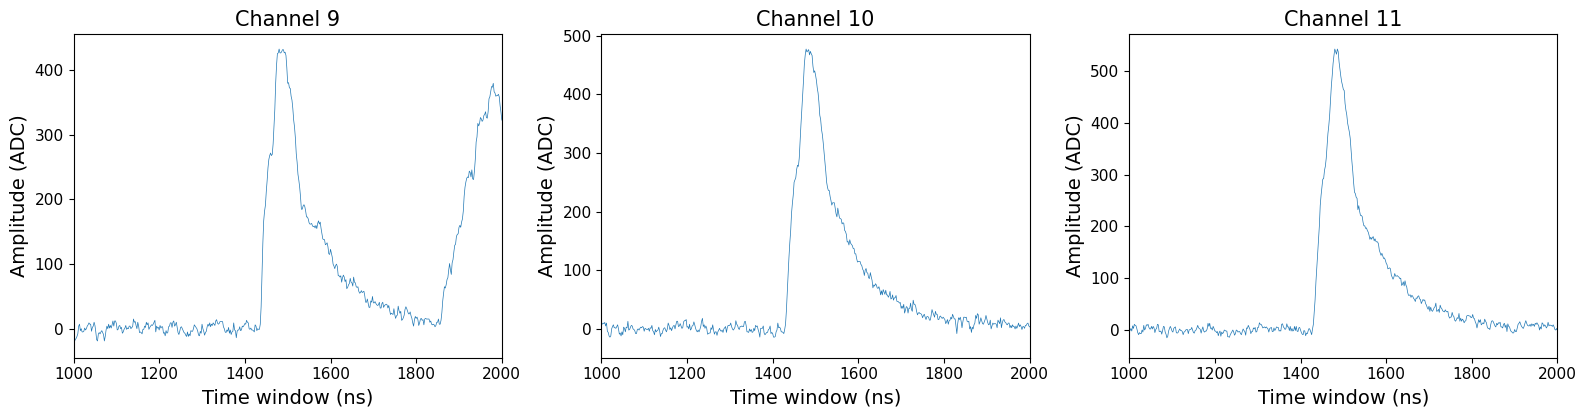

-------------------------- Evt = 7 --------------------------


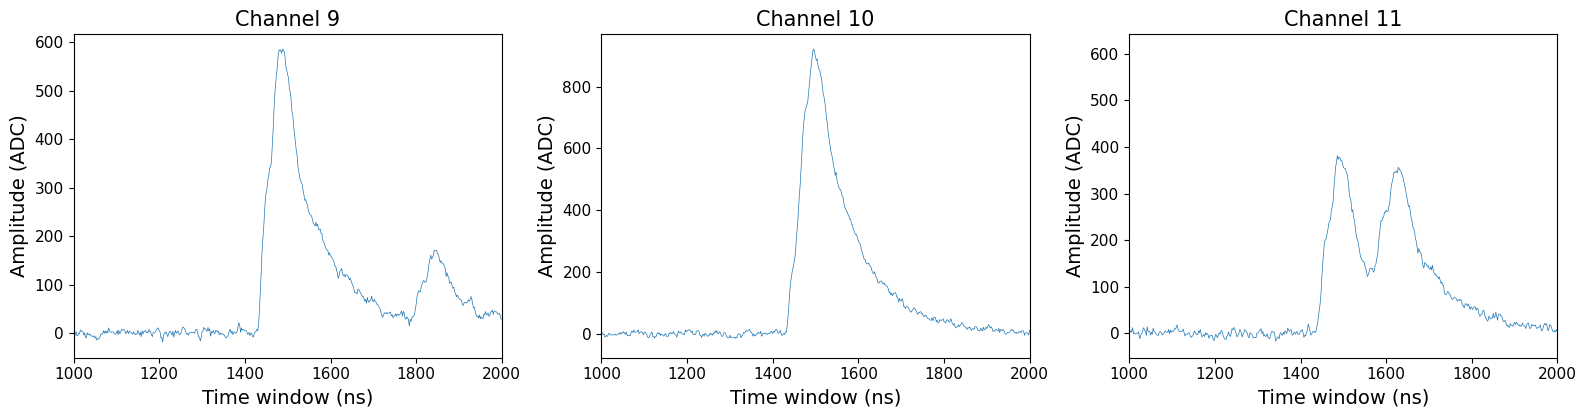

-------------------------- Evt = 8 --------------------------


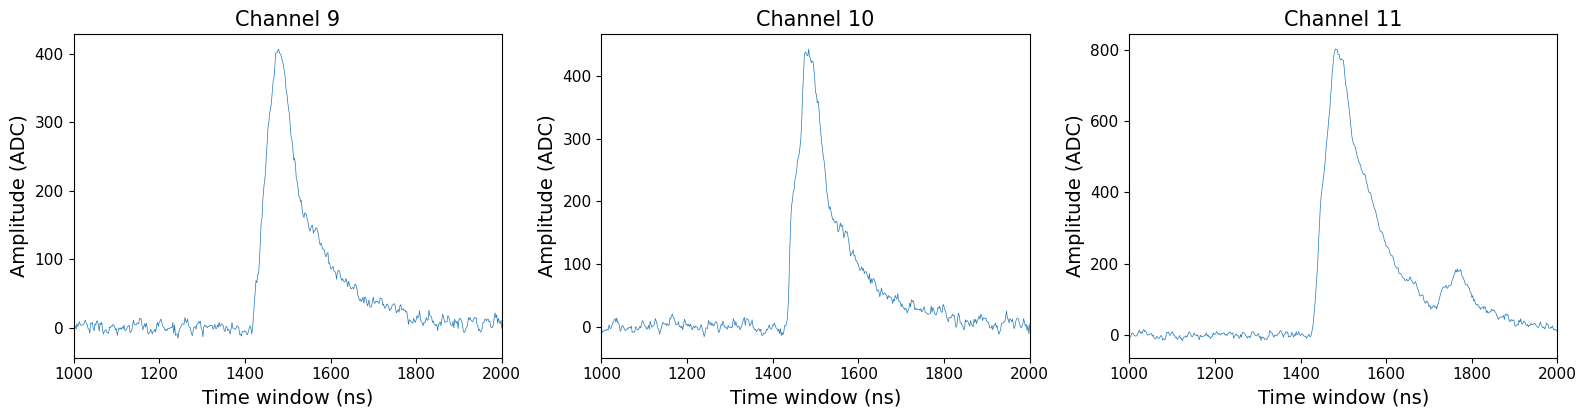

-------------------------- Evt = 9 --------------------------


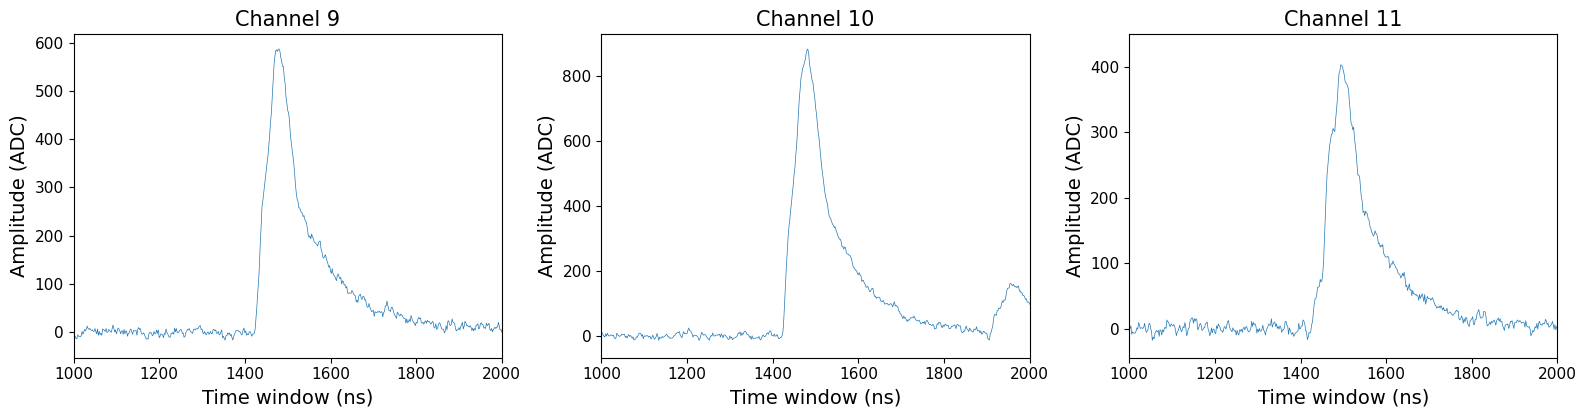

In [10]:
for sel_evt in range(10):
    print(f'-------------------------- Evt = {sel_evt} --------------------------')
    fig, axs = plt.subplots(1, 3, figsize=(16, 4.3))
    for k, ch in enumerate(trigger_chs):
        j = k%3
        sel_wf = trigg_cwfs_dict[ch][sel_evt]
        axs[j].plot(2*np.arange(len(sel_wf)), sel_wf, linewidth=0.5)
        axs[j].set_xlabel('Time window (ns)', fontsize=14)
        axs[j].set_ylabel('Amplitude (ADC)', fontsize=14)
        axs[j].set_title(f"Channel {ch}", fontsize=15)
        axs[j].set_xlim(1000, 2000)
    plt.tight_layout()
    plt.show()

## SG filter:

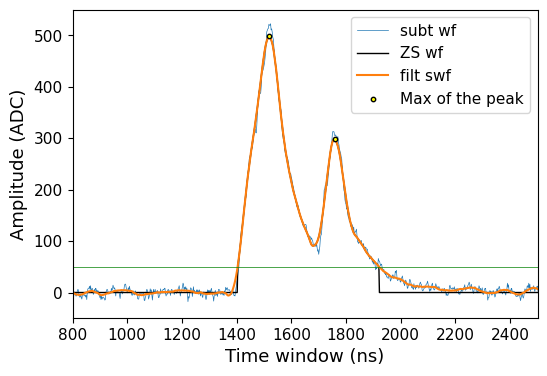

In [11]:
sel_ch  = 11
sel_evt = 1

sel_wf = trigg_cwfs_dict      [sel_ch][sel_evt]
fswf   = sg_filt_trigg_dict   [sel_ch][sel_evt]
zswf   = zs_sg_filt_trigg_dict[sel_ch][sel_evt]

sel_idxs    = idx_peaks_ch_trigg_dict   [sel_ch][sel_evt]
sel_heights = height_peaks_ch_trigg_dict[sel_ch][sel_evt]
    
plt.figure(figsize=(6, 4))
plt.plot(2*np.arange(len(sel_wf)), sel_wf, linewidth=0.5, label='subt wf')
plt.plot(2*np.arange(len(zswf)),   zswf,   linewidth=1.,  label='ZS wf'   , color='k')
plt.plot(2*np.arange(len(fswf)),   fswf,   linewidth=1.5, label='filt swf')
plt.scatter(2*sel_idxs, sel_heights, color='yellow', edgecolors='black', marker='o', s=10, zorder=2, label=f'Max of the peak')

plt.axhline(y=thr_ADC, color='green', linewidth=0.5)
plt.xlabel('Time window (ns)', fontsize=13)
plt.ylabel('Amplitude (ADC)',  fontsize=13)
plt.xlim(800, 2500)
plt.legend()
plt.show()

In [12]:
for idx in range(len(sel_idxs)-1):
    zswf_sel = zswf[sel_idxs[idx]:sel_idxs[idx+1]]
    if np.any(zswf_sel==0):
        continue
    else:
        sel_heights[idx+1] = sel_heights[idx+1] - np.min(zswf_sel)

In [13]:
def peak_height_deconv(zs_waveform, peaks, heights):
    for idx_peak in range(len(peaks)-1):
        zswf_sel = zs_waveform[peaks[idx_peak]:peaks[idx_peak+1]]
        if np.any(zswf_sel == 0):
            continue
        else:
            heights[idx_peak+1] -= np.min(zswf_sel)
    return heights

In [14]:
height_peaks_deconv_ch_trigg_dict = {ch: np.array([peak_height_deconv(wf,
                                                                      idx_peaks_ch_trigg_dict   [ch][i],
                                                                      height_peaks_ch_trigg_dict[ch][i].copy())
                                     for i, wf in enumerate(zs_sg_filt_trigg_dict[ch])], dtype=object)
                                     for ch in trigger_chs}

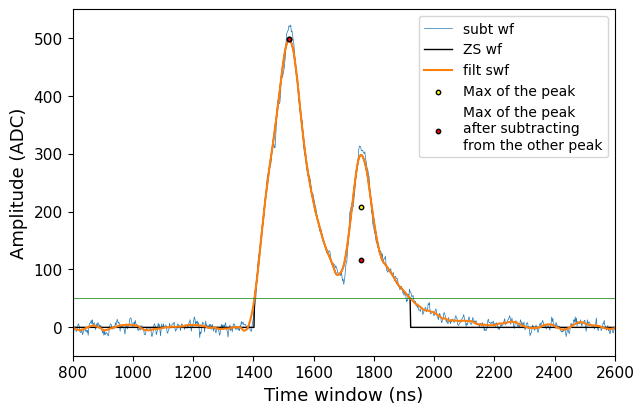

In [15]:
sel_ch  = 11
sel_evt = 1

sel_wf = trigg_cwfs_dict      [sel_ch][sel_evt]
fswf   = sg_filt_trigg_dict   [sel_ch][sel_evt]
zswf   = zs_sg_filt_trigg_dict[sel_ch][sel_evt]

sel_idxs     = idx_peaks_ch_trigg_dict          [sel_ch][sel_evt]
sel_heights1 = height_peaks_ch_trigg_dict       [sel_ch][sel_evt]
sel_heights2 = height_peaks_deconv_ch_trigg_dict[sel_ch][sel_evt]
    
plt.figure(figsize=(7, 4.5))
plt.plot(2*np.arange(len(sel_wf)), sel_wf, linewidth=0.5, label='subt wf')
plt.plot(2*np.arange(len(zswf)),   zswf,   linewidth=1.,  label='ZS wf'   , color='k')
plt.plot(2*np.arange(len(fswf)),   fswf,   linewidth=1.5, label='filt swf')
plt.scatter(2*sel_idxs, sel_heights1, color='yellow', edgecolors='black', marker='o', s=10, zorder=2, label=f'Max of the peak')
plt.scatter(2*sel_idxs, sel_heights2, color='red', edgecolors='black', marker='o', s=10, zorder=2, label=f'Max of the peak \nafter subtracting \nfrom the other peak')

plt.axhline(y=thr_ADC, color='green', linewidth=0.5)
plt.xlabel('Time window (ns)', fontsize=13)
plt.ylabel('Amplitude (ADC)',  fontsize=13)
plt.xlim(800, 2600)
plt.legend(fontsize=10)
plt.show()

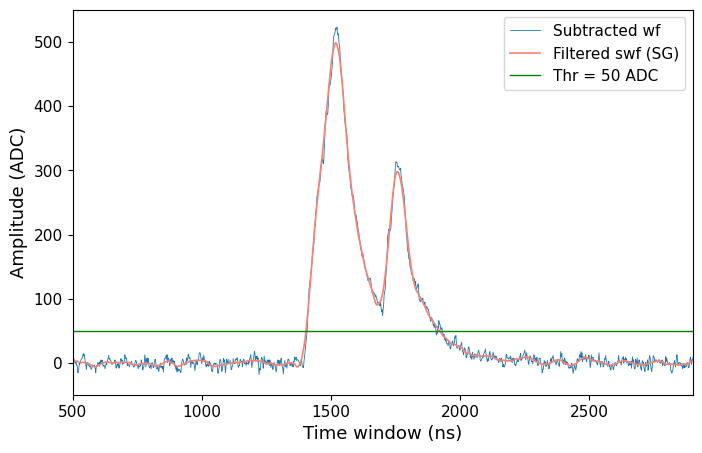

In [16]:
sel_ch  = 11
sel_evt = 1

sel_wf = trigg_cwfs_dict      [sel_ch][sel_evt]
fswf   = sg_filt_trigg_dict   [sel_ch][sel_evt]
zswf   = zs_sg_filt_trigg_dict[sel_ch][sel_evt]
    
plt.figure(figsize=(8, 5))
plt.plot(2*np.arange(len(sel_wf)), sel_wf, linewidth=0.6, label='Subtracted wf')
plt.plot(2*np.arange(len(fswf)),   fswf,   linewidth=1.2, label='Filtered swf (SG)', color='salmon')
#plt.plot(2*np.arange(len(zswf)),   zswf,   linewidth=0.6,  label='ZeroSuppressed wf', color='k')

plt.axhline(y=thr_ADC, color='green', linewidth=1, label=f'Thr = {thr_ADC} ADC')
plt.xlabel('Time window (ns)', fontsize=13)
plt.ylabel('Amplitude (ADC)',  fontsize=13)
plt.xlim(500, 2900)
plt.legend(fontsize=11)
plt.show()

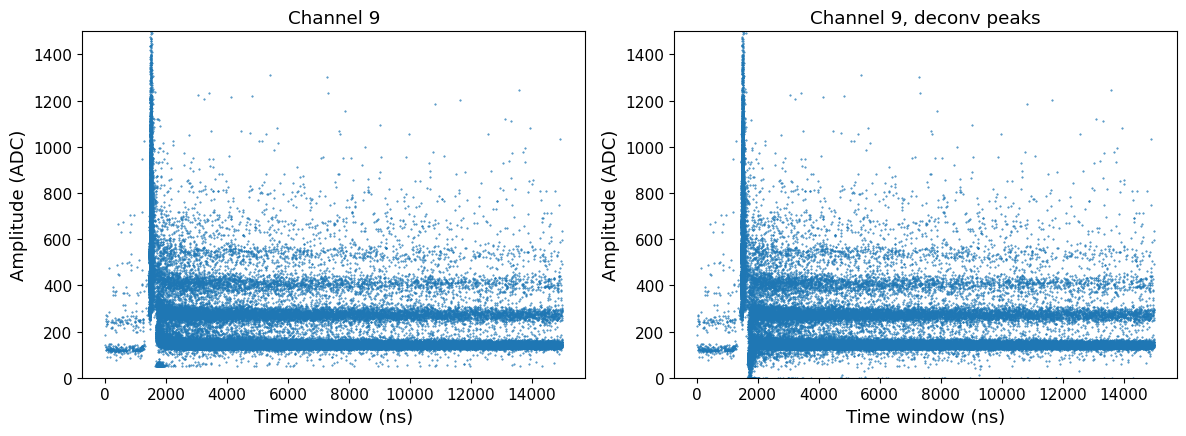

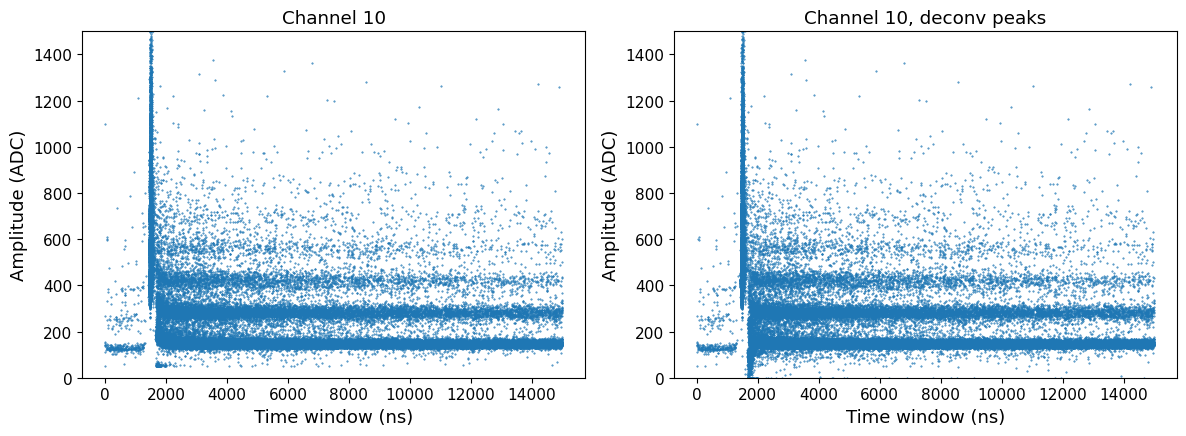

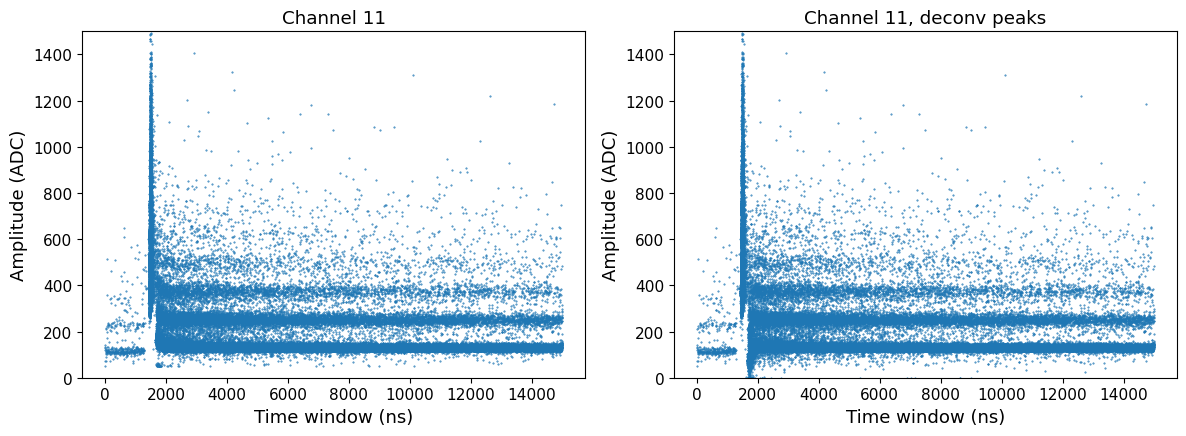

In [17]:
for ch in trigger_chs:
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4.5))
    ax0.scatter(2*np.concatenate((idx_peaks_ch_trigg_dict[ch])), np.concatenate((height_peaks_ch_trigg_dict       [ch])), s=0.2)
    ax1.scatter(2*np.concatenate((idx_peaks_ch_trigg_dict[ch])), np.concatenate((height_peaks_deconv_ch_trigg_dict[ch])), s=0.2)
    ax0.set_ylim(0, 1500)
    ax0.set_title(f'Channel {ch}')
    ax0.set_xlabel('Time window (ns)', fontsize=13)
    ax0.set_ylabel('Amplitude (ADC)',  fontsize=13)
    ax1.set_ylim(0, 1500)
    ax1.set_title(f'Channel {ch}, deconv peaks')
    ax1.set_xlabel('Time window (ns)', fontsize=13)
    ax1.set_ylabel('Amplitude (ADC)',  fontsize=13)
    plt.tight_layout()
    plt.show()

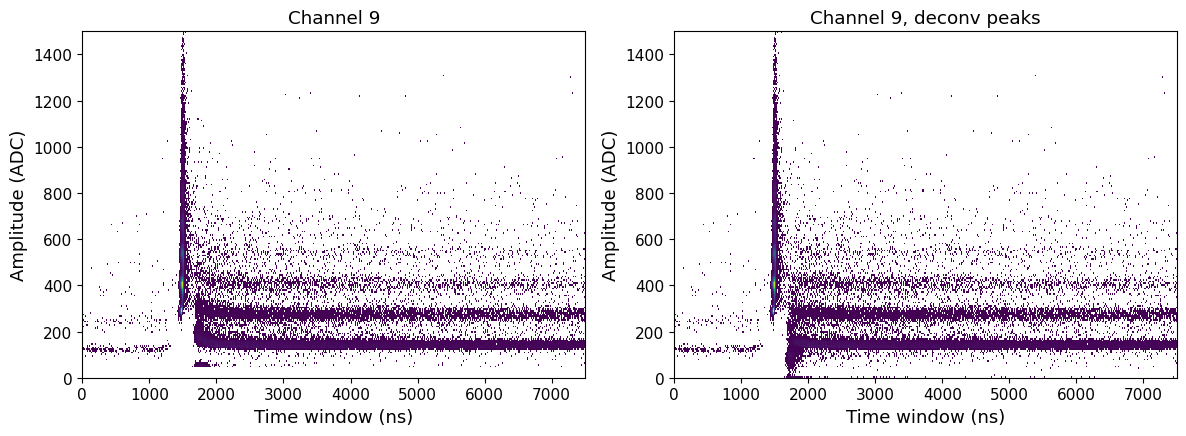

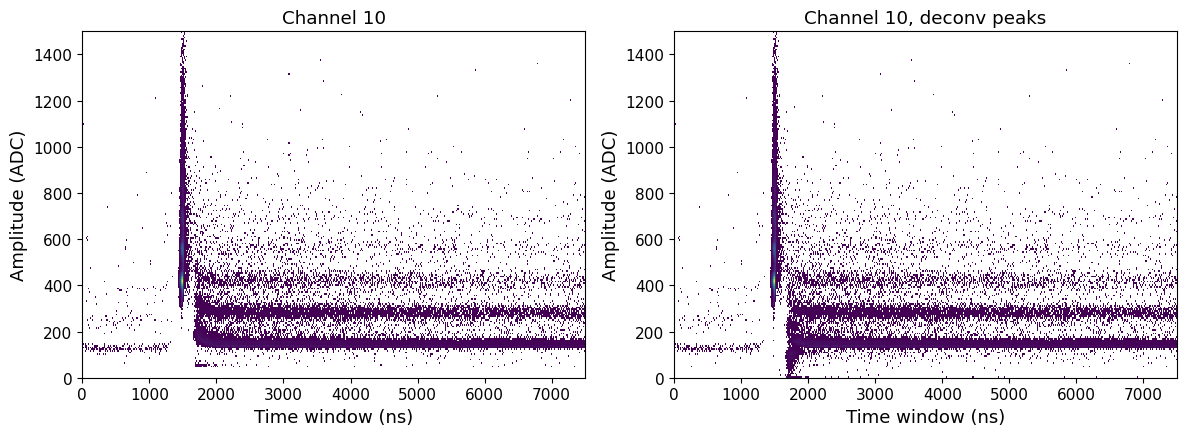

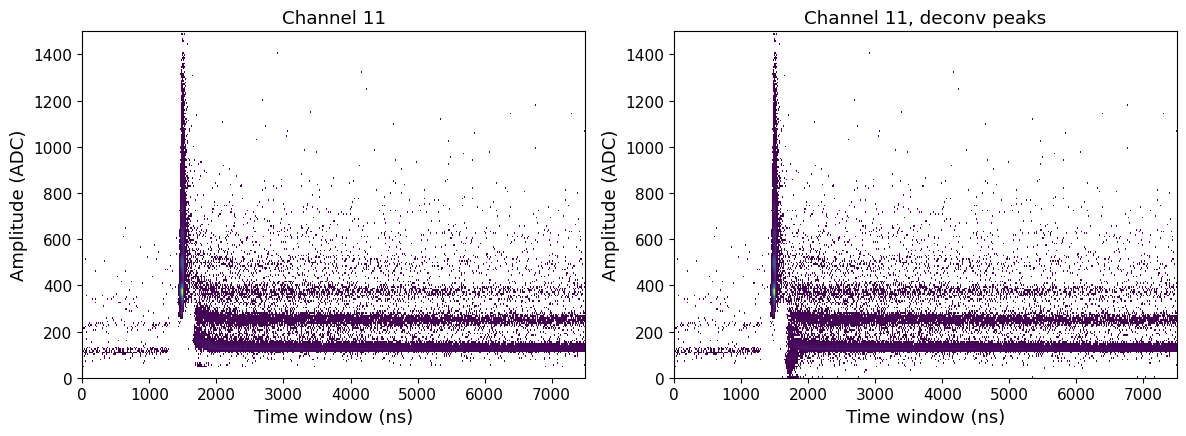

In [18]:
for ch in trigger_chs:
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4.5))
    ax0.hist2d(2*np.concatenate((idx_peaks_ch_trigg_dict[ch])), np.concatenate((height_peaks_ch_trigg_dict       [ch])), bins=(500, 200), range=((0, 7500), (0, 1500)), cmin=1)
    ax1.hist2d(2*np.concatenate((idx_peaks_ch_trigg_dict[ch])), np.concatenate((height_peaks_deconv_ch_trigg_dict[ch])), bins=(500, 200), range=((0, 7500), (0, 1500)), cmin=1)
    ax0.set_title(f'Channel {ch}')
    ax0.set_xlabel('Time window (ns)', fontsize=13)
    ax0.set_ylabel('Amplitude (ADC)',  fontsize=13)
    ax1.set_title(f'Channel {ch}, deconv peaks')
    ax1.set_xlabel('Time window (ns)', fontsize=13)
    ax1.set_ylabel('Amplitude (ADC)',  fontsize=13)
    plt.tight_layout()
    plt.show()

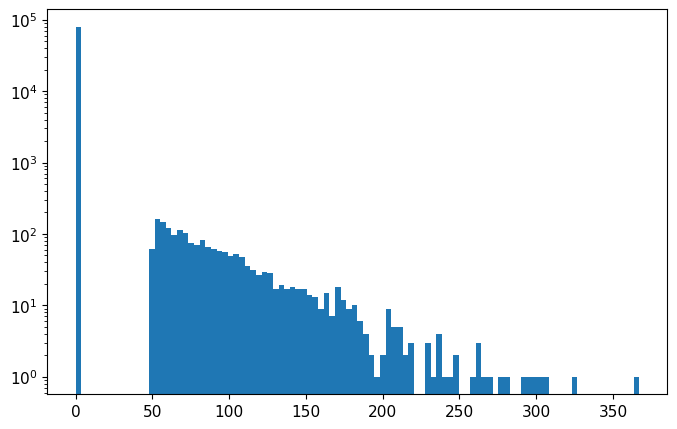

In [19]:
plt.hist(np.concatenate((height_peaks_ch_trigg_dict[ch])) - np.concatenate((height_peaks_deconv_ch_trigg_dict[ch])), bins=100, log=True);

## Normal SiPMs

In [20]:
normal_chs  = range(9)
std_bsl_thr = 15

In [21]:
filt_wfs_dict = {ch: np.array([(evt, wf)
                               for evt, wf in enumerate(pf.wfs_from_rawtree(RawTree, ch)) if np.std(wf) > std_bsl_thr], dtype=object)
                 for ch in normal_chs}

#filt_evts      = np.unique(np.concatenate(np.array([filt_wfs_dict[ch].T[0] for ch in normal_chs])))
filt_evts_dict = {ch: filt_wfs_dict[ch].T[0]
                  if len(filt_wfs_dict[ch])!=0 else []
                  for ch in normal_chs}

## Baseline subtraction
subt_wfs_dict = {ch: np.array([pf.subtract_baseline(fwf,
                                          mode=True,
                                          wf_range_bsl=(0, max_smpl_bsl))
                                          for _, fwf in filt_wfs_dict[ch]])
                 if len(filt_wfs_dict[ch])!=0 else []
                 for ch in normal_chs}

## Apply the Savitzky-Golay filter to smooth the wf
sg_filt_swfs_dict = {ch: savgol_filter(subt_wfs_dict[ch],
                                       window_length=sg_filter_window,
                                       polyorder=sg_filter_polyorder)
                     if len(subt_wfs_dict[ch]) != 0 else []
                     for ch in normal_chs}

## Noise suppression
zs_sg_filt_swfs_dict = {ch: pf.noise_suppression(sg_filt_swfs_dict[ch],
                                                 threshold=thr_ADC)
                        if len(sg_filt_swfs_dict[ch]) != 0 else []
                        for ch in normal_chs}

## Get peaks above thr_ADC
#idx_peaks_ch_dict = {ch: np.array(list(map(pf.get_peaks_peakutils, zs_sg_filt_swfs_dict[ch])), dtype=object)
#                     for ch in normal_chs}

idx_peaks_ch_dict = {ch: np.array(list(map(partial_get_peaks_peakutils, zs_sg_filt_swfs_dict[ch])), dtype=object)
                     for ch in normal_chs}

height_peaks_ch_dict = {ch: np.array([pf.peak_height(wf, idx_peaks_ch_dict[ch][i])
                                      for i,wf in enumerate(zs_sg_filt_swfs_dict[ch])], dtype=object)
                        for ch in normal_chs}

In [22]:
#height_peaks_ch_dict = {ch: np.array([pf.peak_height(wf, idx_peaks_ch_dict[ch][i])
#                                      for i,wf in enumerate(zs_sg_filt_swfs_dict[ch])], dtype=object)
for ch in normal_chs:
    for i,wf in enumerate(zs_sg_filt_swfs_dict[ch]):
        print(type(pf.peak_height(wf, idx_peaks_ch_dict[ch][i])))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.nd

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.nd

In [23]:
height_peaks_deconv_ch_dict = {ch: np.array([peak_height_deconv(wf,
                                                                idx_peaks_ch_dict   [ch][i],
                                                                height_peaks_ch_dict[ch][i].copy())
                               for i, wf in enumerate(zs_sg_filt_swfs_dict[ch])], dtype=object)
                               for ch in normal_chs}

In [24]:
sel_ch = 0
for evt, (hs1, hs2) in enumerate(zip(height_peaks_ch_dict[sel_ch], height_peaks_deconv_ch_dict[sel_ch])):
    for h1, h2 in zip(hs1, hs2):
        if h1!=h2:
            print(evt)

112
190
787
889
1130
1225
1244
1319
1351
1394
1436
1657
1772
1857
1950
1958
1976
2033
2111
2320
2346
2421
2470
2525
2554
2590
2718
3055
3103
3106
3558
3859
3875
3915
4340
4374
4471
4479
4574
4611
4614


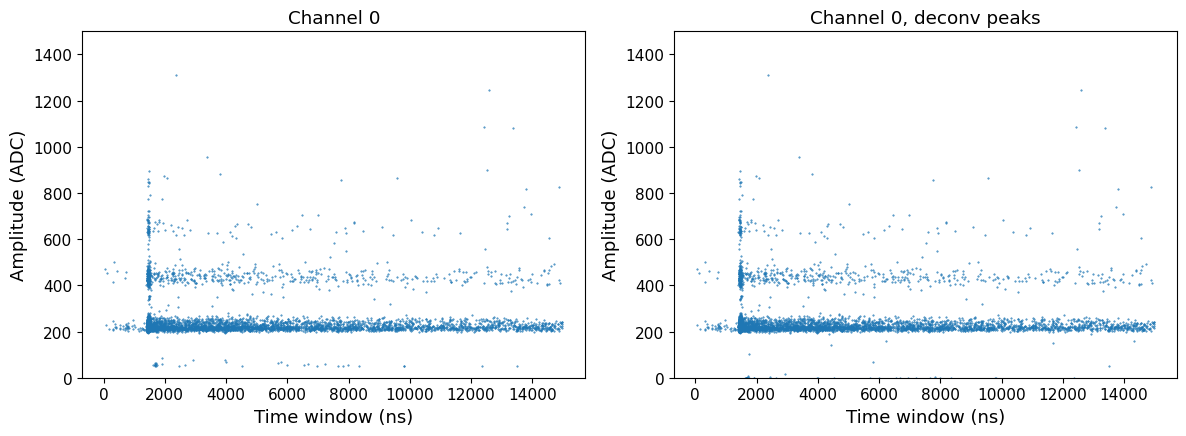

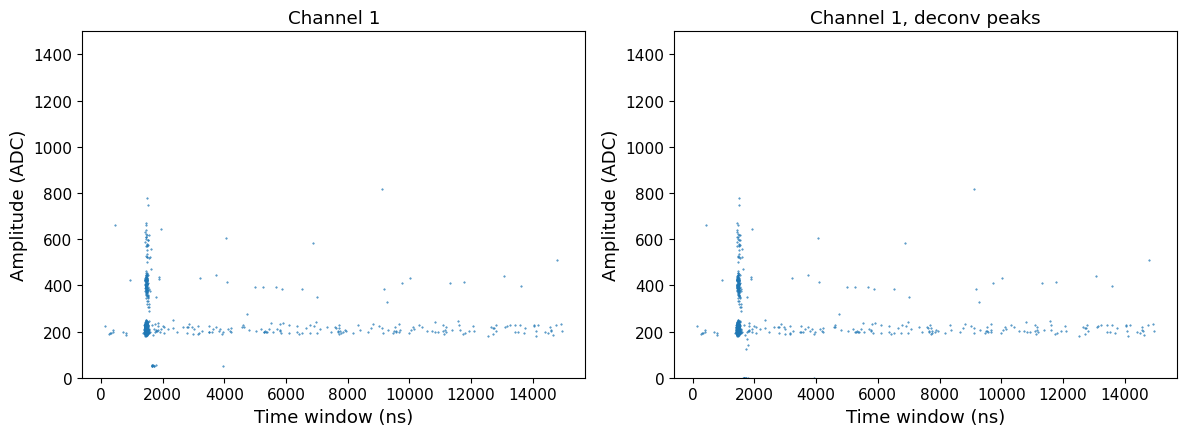

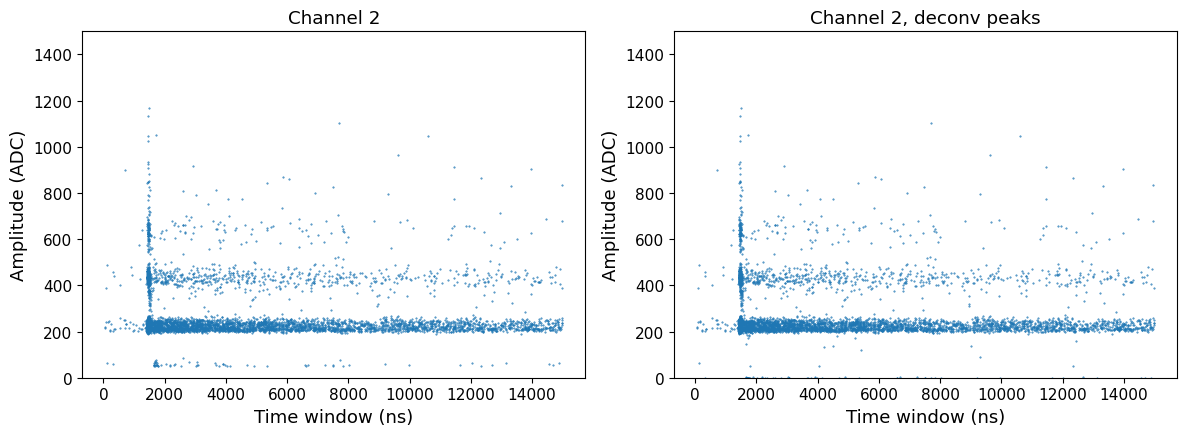

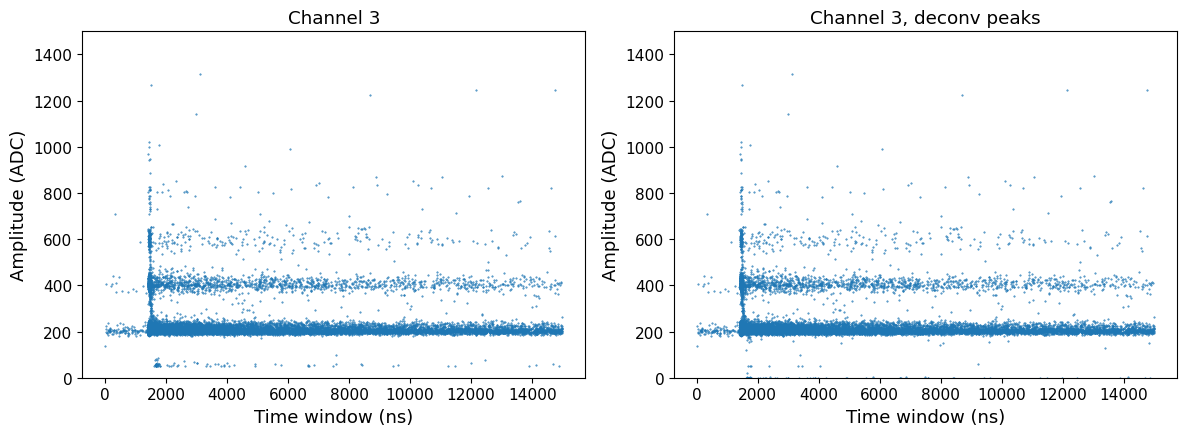

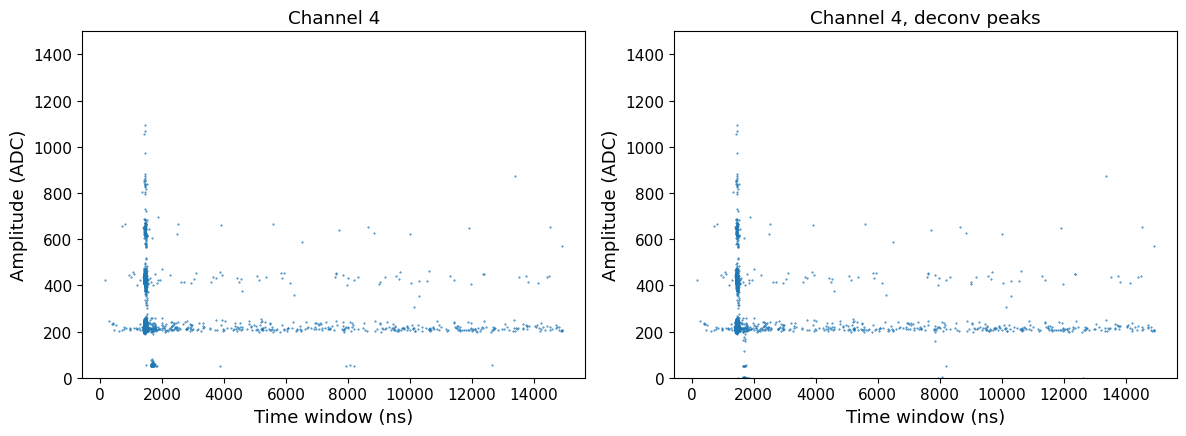

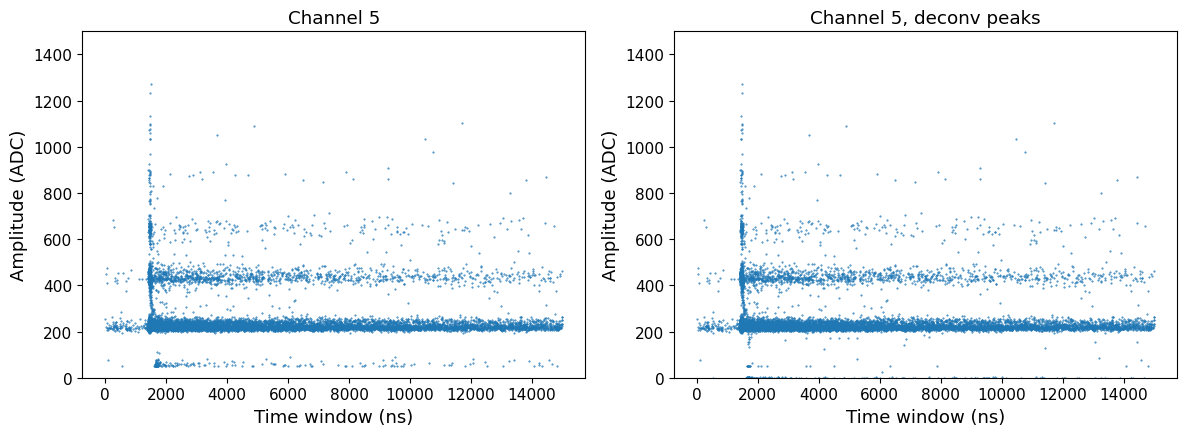

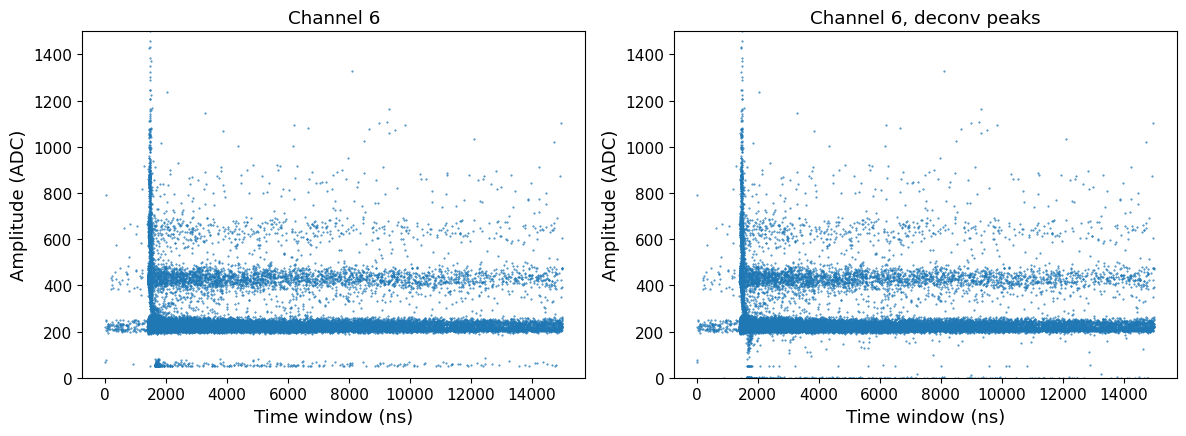

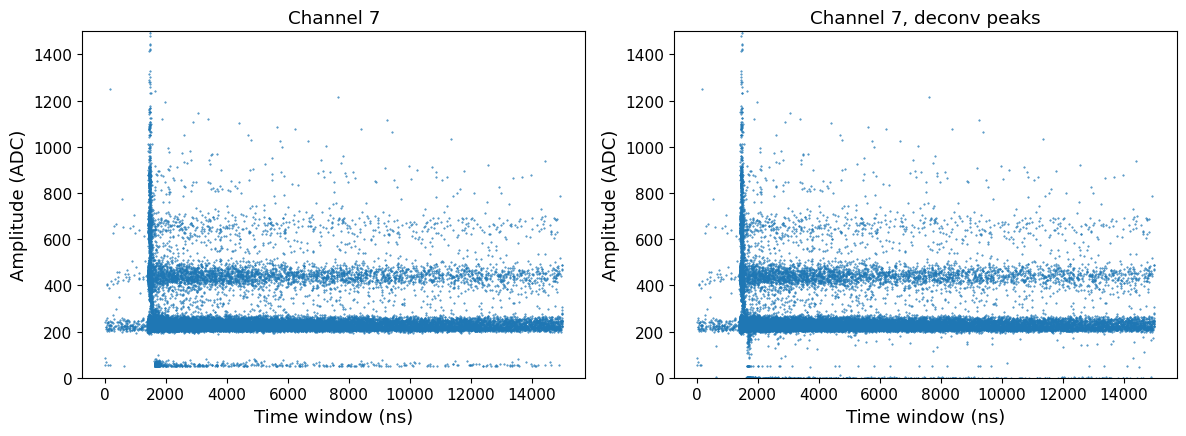

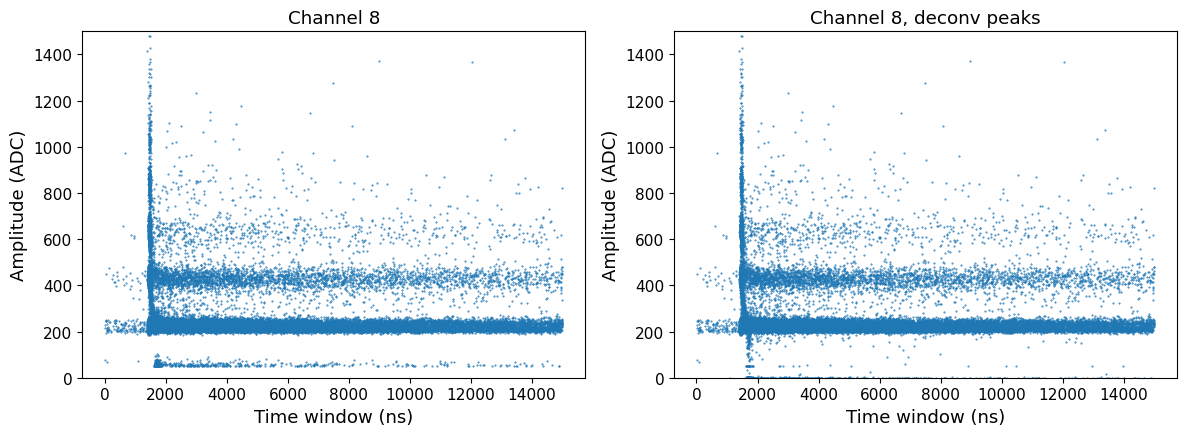

In [25]:
for ch in normal_chs:
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4.5))
    ax0.scatter(2*np.concatenate((idx_peaks_ch_dict[ch])), np.concatenate((height_peaks_ch_dict       [ch])), s=0.2)
    ax1.scatter(2*np.concatenate((idx_peaks_ch_dict[ch])), np.concatenate((height_peaks_deconv_ch_dict[ch])), s=0.2)
    ax0.set_ylim(0, 1500)
    ax0.set_title(f'Channel {ch}')
    ax0.set_xlabel('Time window (ns)', fontsize=13)
    ax0.set_ylabel('Amplitude (ADC)',  fontsize=13)
    ax1.set_ylim(0, 1500)
    ax1.set_title(f'Channel {ch}, deconv peaks')
    ax1.set_xlabel('Time window (ns)', fontsize=13)
    ax1.set_ylabel('Amplitude (ADC)',  fontsize=13)
    plt.tight_layout()
    plt.show()

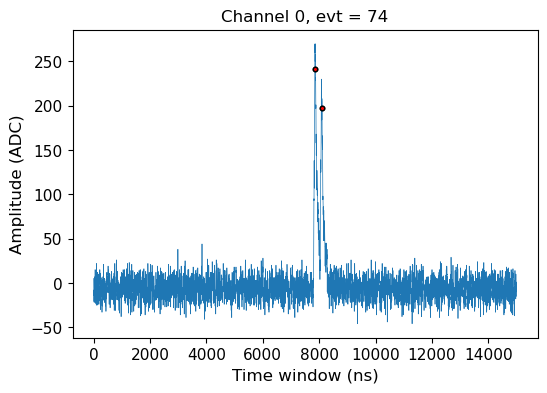

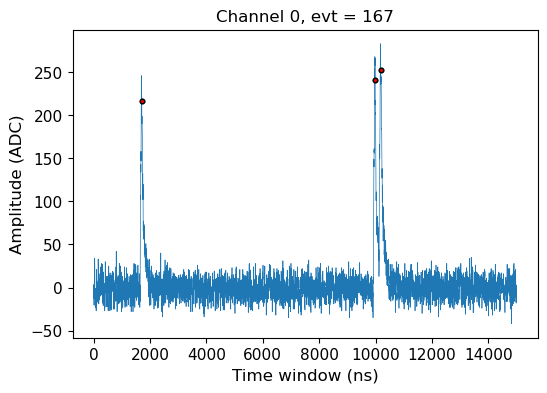

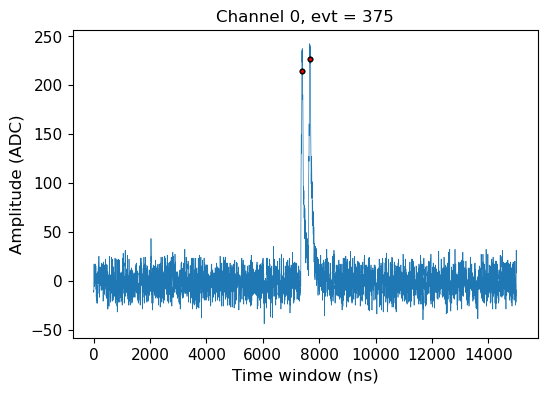

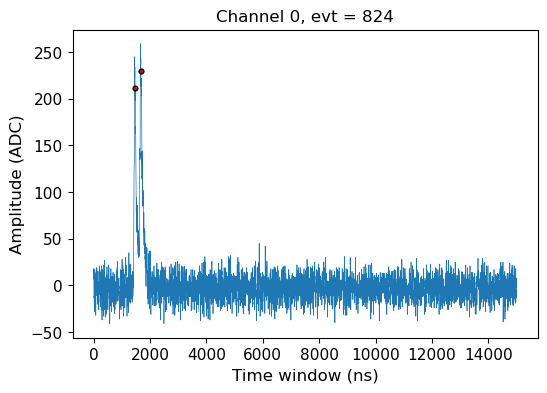

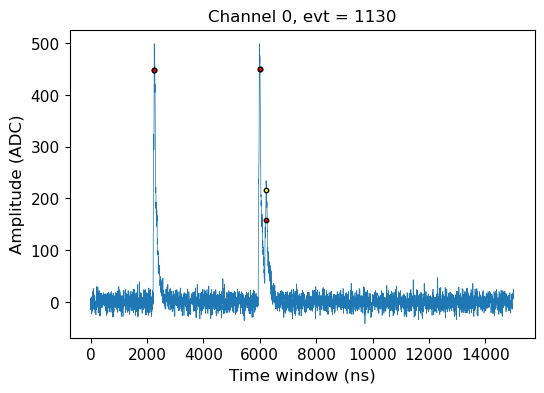

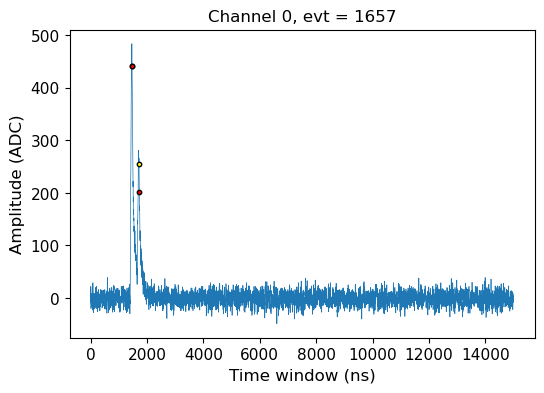

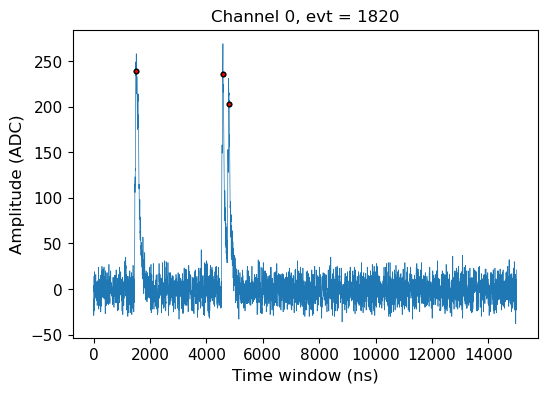

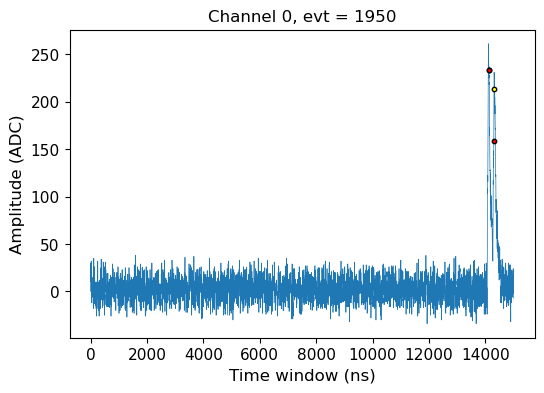

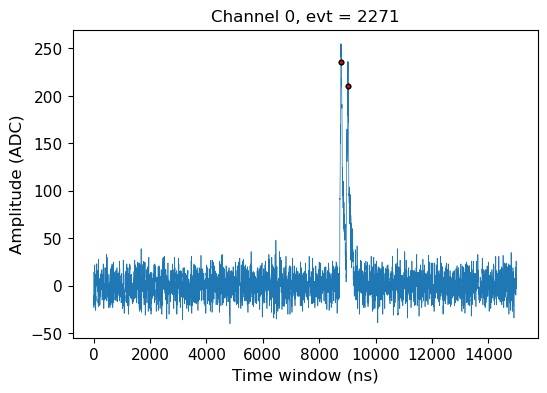

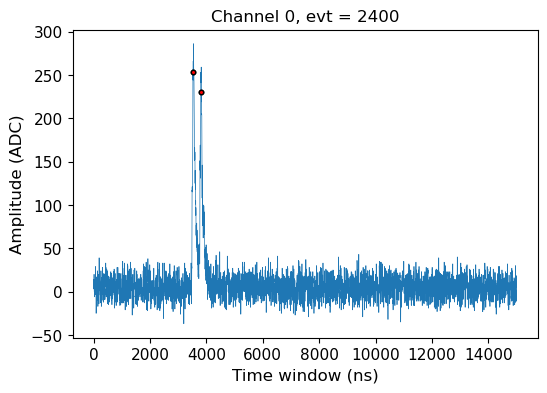

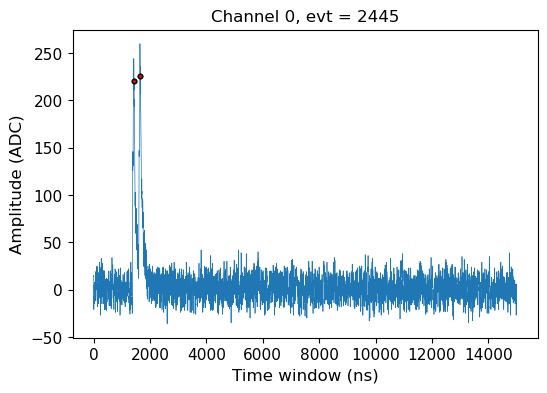

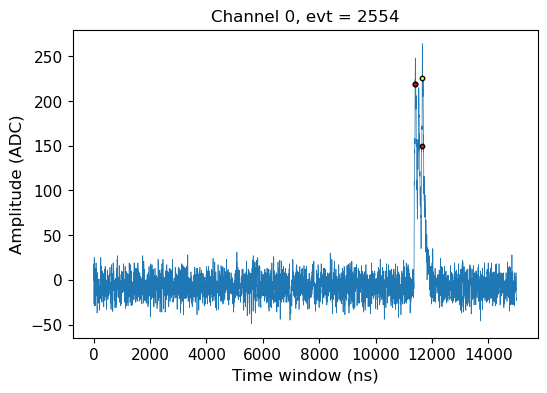

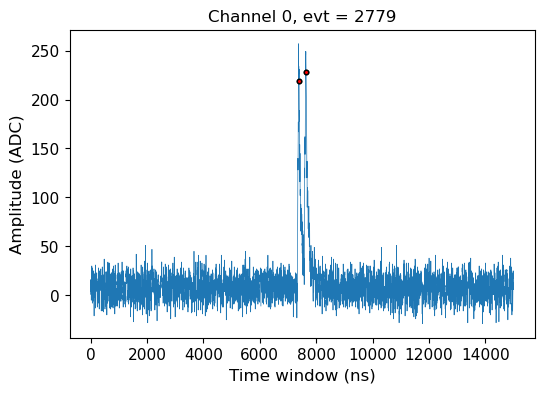

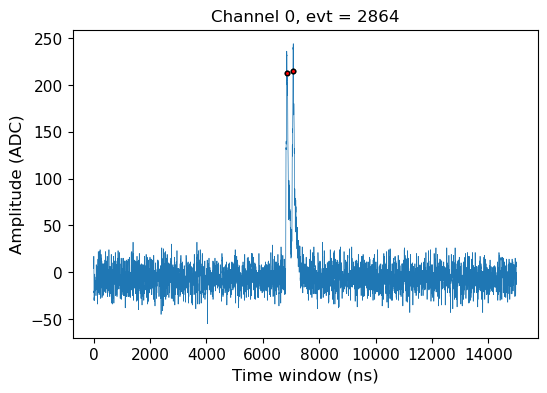

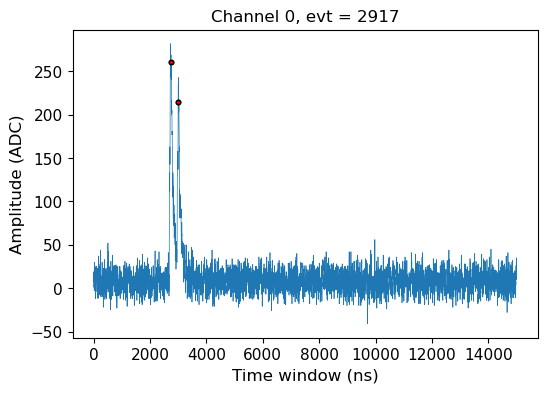

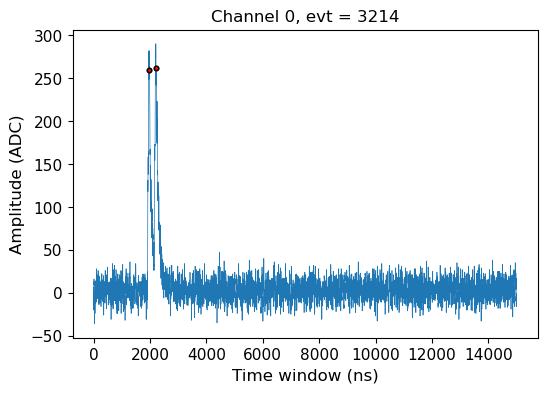

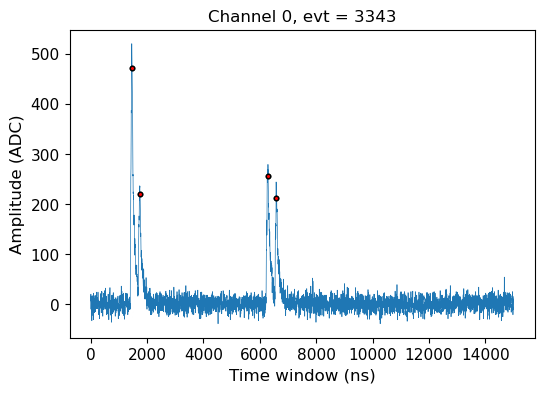

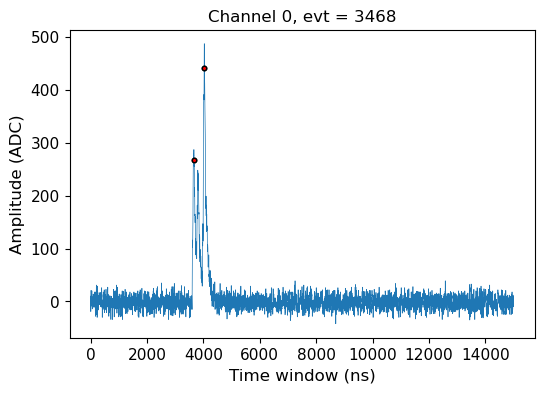

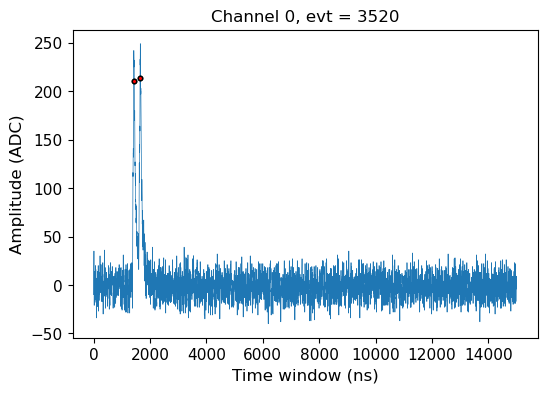

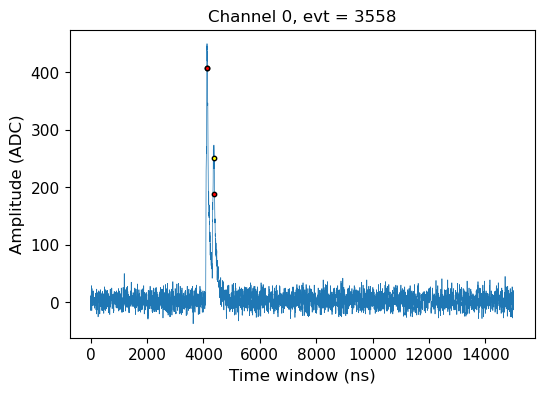

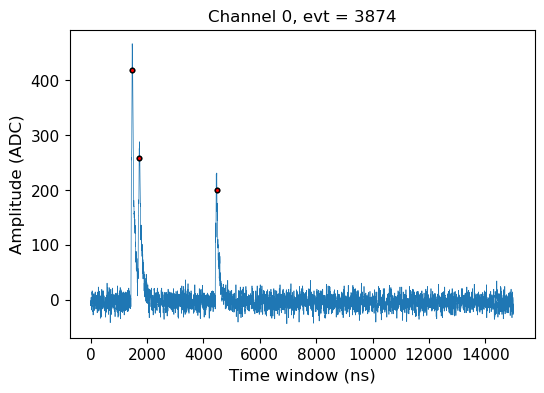

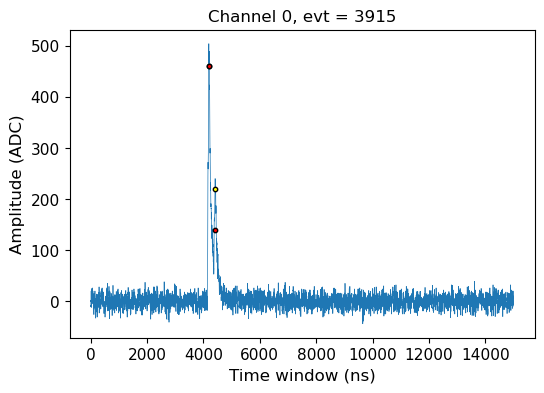

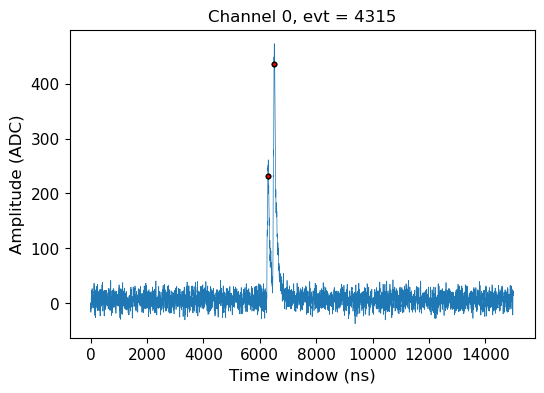

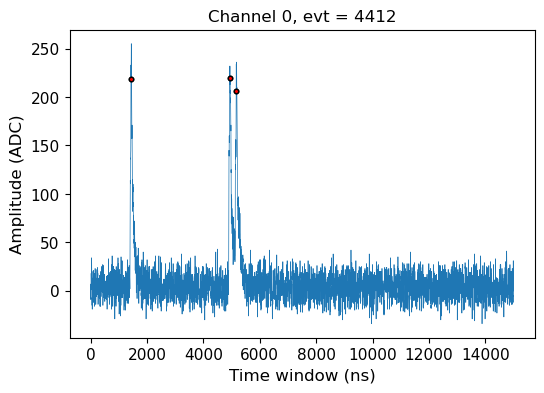

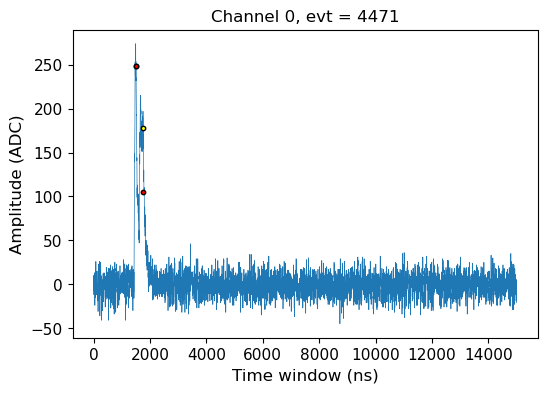

In [26]:
sel_ch = 0
for sel_evt in [74, 167, 375, 824, 1130, 1657, 1820, 1950, 2271, 2400, 2445, 2554, 2779, 2864, 2917, 3214, 3343, 3468, 3520, 3558, 3874, 3915, 4315, 4412, 4471]:
    plt.figure(figsize=(6, 4))
    sel_wf = subt_wfs_dict[sel_ch][sel_evt]
    plt.plot(2*np.arange(len(sel_wf)), sel_wf, linewidth=0.5)
    
    sel_idxs     = idx_peaks_ch_dict          [sel_ch][sel_evt]
    sel_heights1 = height_peaks_ch_dict       [sel_ch][sel_evt]
    sel_heights2 = height_peaks_deconv_ch_dict[sel_ch][sel_evt]
    plt.scatter(2*sel_idxs, sel_heights1, color='yellow', edgecolors='black', marker='o', s=10, zorder=2, label=f'Max of the peak')
    plt.scatter(2*sel_idxs, sel_heights2, color='red',    edgecolors='black', marker='o', s=10, zorder=2, label=f'Max of the peak')

    plt.xlabel('Time window (ns)', fontsize=12)
    plt.ylabel('Amplitude (ADC)',  fontsize=12)
    plt.title(f"Channel {sel_ch}, evt = {sel_evt}", fontsize=12)
    #plt.xlim(500, 2500)
    plt.show()

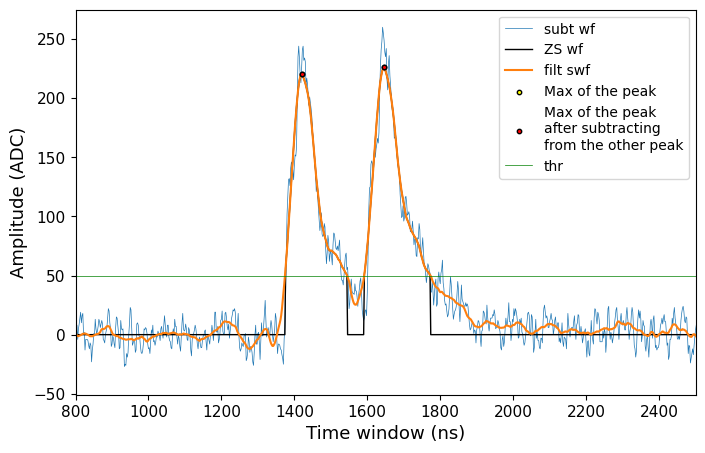

In [27]:
sel_ch  = 0
sel_evt = 2445

sel_wf = subt_wfs_dict       [sel_ch][sel_evt]
fswf   = sg_filt_swfs_dict   [sel_ch][sel_evt]
zswf   = zs_sg_filt_swfs_dict[sel_ch][sel_evt]

sel_idxs     = idx_peaks_ch_dict          [sel_ch][sel_evt]
sel_heights1 = height_peaks_ch_dict       [sel_ch][sel_evt]
sel_heights2 = height_peaks_deconv_ch_dict[sel_ch][sel_evt]
    
plt.figure(figsize=(8, 5))
plt.plot(2*np.arange(len(sel_wf)), sel_wf, linewidth=0.5, label='subt wf')
plt.plot(2*np.arange(len(zswf)),   zswf,   linewidth=1.,  label='ZS wf'   , color='k')
plt.plot(2*np.arange(len(fswf)),   fswf,   linewidth=1.5, label='filt swf')
plt.scatter(2*sel_idxs, sel_heights1, color='yellow', edgecolors='black', marker='o', s=10, zorder=2, label=f'Max of the peak')
plt.scatter(2*sel_idxs, sel_heights2, color='red',    edgecolors='black', marker='o', s=10, zorder=2, label=f'Max of the peak \nafter subtracting \nfrom the other peak')

plt.axhline(y=thr_ADC, color='green', linewidth=0.5, label='thr')
plt.xlabel('Time window (ns)', fontsize=13)
plt.ylabel('Amplitude (ADC)',  fontsize=13)
plt.xlim(800, 2500)
plt.legend(fontsize=10)
plt.show()

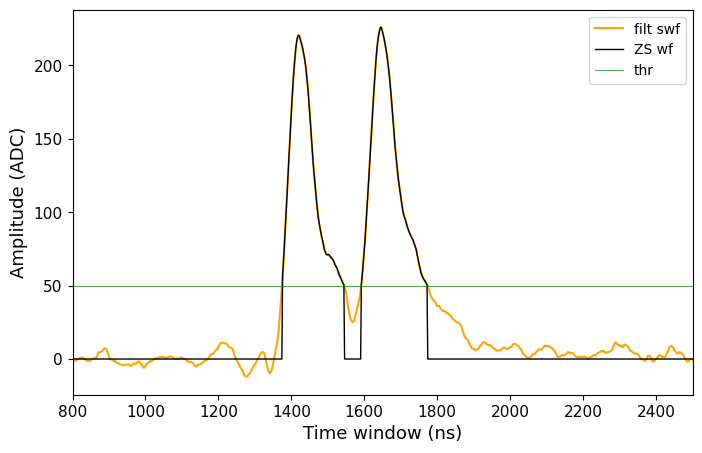

In [28]:
plt.figure(figsize=(8, 5))
plt.plot(2*np.arange(len(fswf)), fswf, linewidth=1.5, label='filt swf', color='orange')
plt.plot(2*np.arange(len(zswf)),   zswf,   linewidth=1.,  label='ZS wf'   , color='k')
plt.axhline(y=thr_ADC, color='green', linewidth=0.5, label='thr')
plt.xlabel('Time window (ns)', fontsize=13)
plt.ylabel('Amplitude (ADC)',  fontsize=13)
plt.xlim(800, 2500)
plt.legend(fontsize=10)
plt.show()

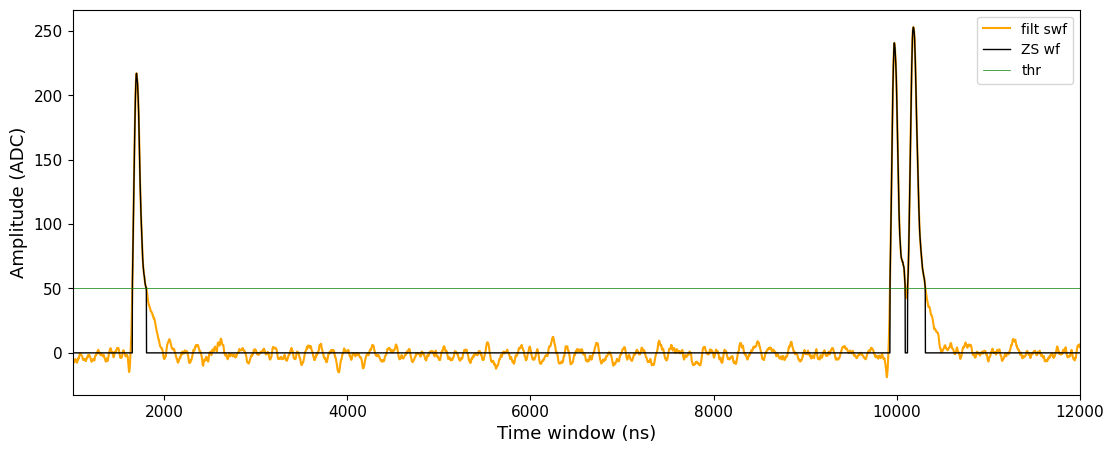

In [29]:
sel_ch  = 0
sel_evt = 167

fswf   = sg_filt_swfs_dict   [sel_ch][sel_evt]
zswf   = zs_sg_filt_swfs_dict[sel_ch][sel_evt]

sel_idxs     = idx_peaks_ch_dict          [sel_ch][sel_evt]
sel_heights1 = height_peaks_ch_dict       [sel_ch][sel_evt]
sel_heights2 = height_peaks_deconv_ch_dict[sel_ch][sel_evt]
    
plt.figure(figsize=(13, 5))
plt.plot(2*np.arange(len(fswf)), fswf, linewidth=1.5, label='filt swf', color='orange')
plt.plot(2*np.arange(len(zswf)),   zswf,   linewidth=1.,  label='ZS wf'   , color='k')
plt.axhline(y=thr_ADC, color='green', linewidth=0.5, label='thr')
plt.xlabel('Time window (ns)', fontsize=13)
plt.ylabel('Amplitude (ADC)',  fontsize=13)
plt.xlim(1000, 12000)
plt.legend(fontsize=10)
plt.show()

In [30]:
waveform   = zswf
indx_test  = np.where((waveform>0))[0]
split_vals = np.where((np.diff(indx_test)>1))[0] + 1
chunks     = np.split(indx_test, split_vals)

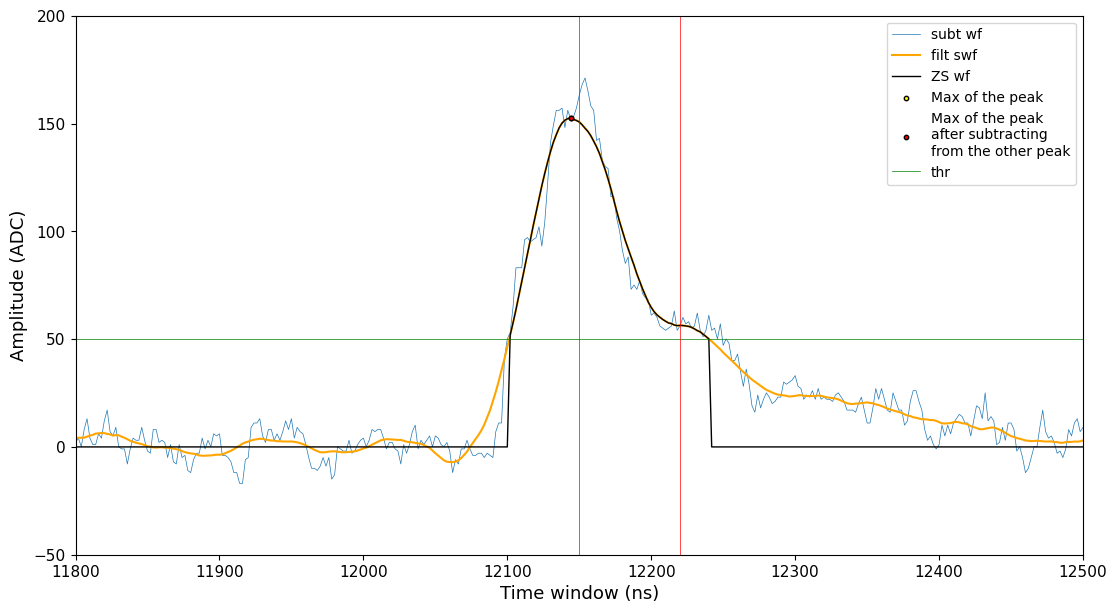

In [31]:
sel_ch  = 10
sel_evt = 0

sel_wf = trigg_cwfs_dict      [sel_ch][sel_evt]
fswf = sg_filt_trigg_dict   [sel_ch][sel_evt]
zswf = zs_sg_filt_trigg_dict[sel_ch][sel_evt]

sel_idxs     = idx_peaks_ch_trigg_dict          [sel_ch][sel_evt]
sel_heights1 = height_peaks_ch_trigg_dict       [sel_ch][sel_evt]
sel_heights2 = height_peaks_deconv_ch_trigg_dict[sel_ch][sel_evt]
    
plt.figure(figsize=(13, 7))
plt.plot(2*np.arange(len(sel_wf)), sel_wf, linewidth=0.5, label='subt wf')
plt.plot(2*np.arange(len(fswf)), fswf, linewidth=1.5, label='filt swf', color='orange')
plt.plot(2*np.arange(len(zswf)), zswf, linewidth=1.,  label='ZS wf'   , color='k')

plt.scatter(2*sel_idxs, sel_heights1, color='yellow', edgecolors='black', marker='o', s=10, zorder=2, label=f'Max of the peak')
plt.scatter(2*sel_idxs, sel_heights2, color='red',    edgecolors='black', marker='o', s=10, zorder=2, label=f'Max of the peak \nafter subtracting \nfrom the other peak')

plt.axhline(y=thr_ADC, color='green',  linewidth=0.5, label='thr')
plt.axvline(x=12150, color='r',  linewidth=0.5)
plt.axvline(x=12220, color='r',  linewidth=0.5)
plt.xlabel('Time window (ns)', fontsize=13)
plt.ylabel('Amplitude (ADC)',  fontsize=13)
plt.xlim(11800, 12500)
plt.ylim(-50, 200)
plt.legend(fontsize=10)
plt.show()

In [32]:
import peakutils

new_indxs = peakutils.indexes(zswf, thres=50, min_dist=100, thres_abs=True)

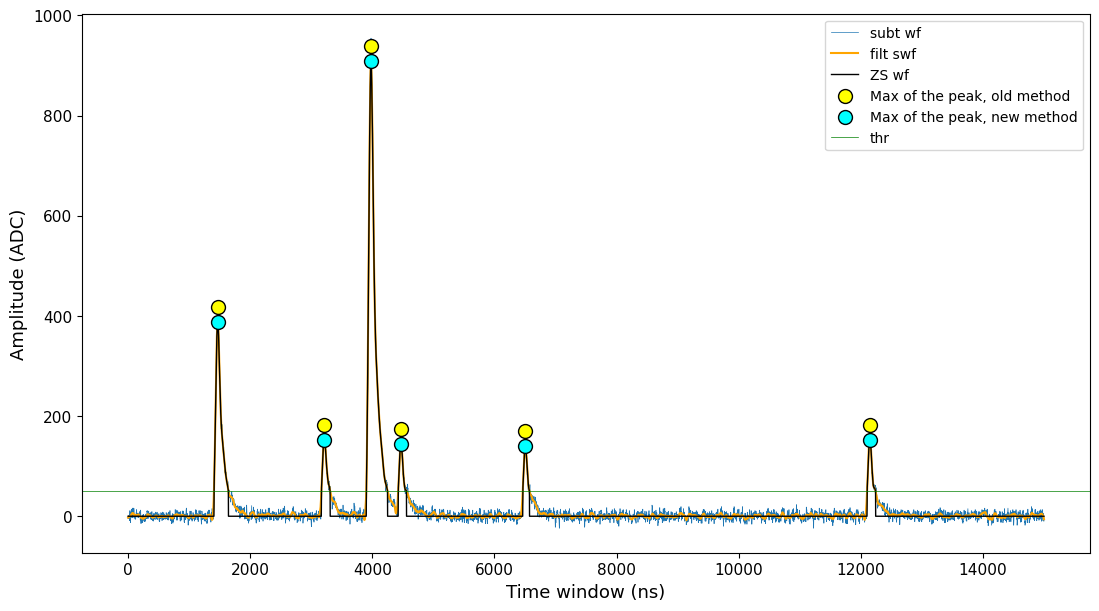

In [33]:
sel_ch  = 10
sel_evt = 0

sel_wf = trigg_cwfs_dict    [sel_ch][sel_evt]
fswf = sg_filt_trigg_dict   [sel_ch][sel_evt]
zswf = zs_sg_filt_trigg_dict[sel_ch][sel_evt]

plt.figure(figsize=(13, 7))
plt.plot(2*np.arange(len(sel_wf)), sel_wf, linewidth=0.5, label='subt wf')
plt.plot(2*np.arange(len(fswf)), fswf, linewidth=1.5, label='filt swf', color='orange')
plt.plot(2*np.arange(len(zswf)), zswf, linewidth=1.,  label='ZS wf'   , color='k')

plt.scatter(2*sel_idxs, sel_heights1+30, color='yellow', edgecolors='black', marker='o', s=100, zorder=2, label=f'Max of the peak, old method')
#plt.scatter(2*sel_idxs, sel_heights2, color='red',    edgecolors='black', marker='o', s=100, zorder=2, label=f'Max of the peak \nafter subtracting \nfrom the other peak')
plt.scatter(2*new_indxs, zswf[new_indxs], color='cyan', edgecolors='black', marker='o', s=100, zorder=2, label=f'Max of the peak, new method')

plt.axhline(y=thr_ADC, color='green',  linewidth=0.5, label='thr')
#for ni in new_indxs:
#    plt.axvline(x=2*ni, color='r',  linewidth=0.5)
plt.xlabel('Time window (ns)', fontsize=13)
plt.ylabel('Amplitude (ADC)',  fontsize=13)
#plt.xlim(11800, 12500)
#plt.ylim(-50, 200)
plt.legend(fontsize=10)
plt.show()

In [34]:
waveform   = zswf
indx_test  = np.where((waveform>0))[0]
split_vals = np.where((np.diff(indx_test)>1))[0] + 1
chunks     = np.split(indx_test, split_vals)

In [35]:
len(chunks), len(sel_idxs)

(6, 6)

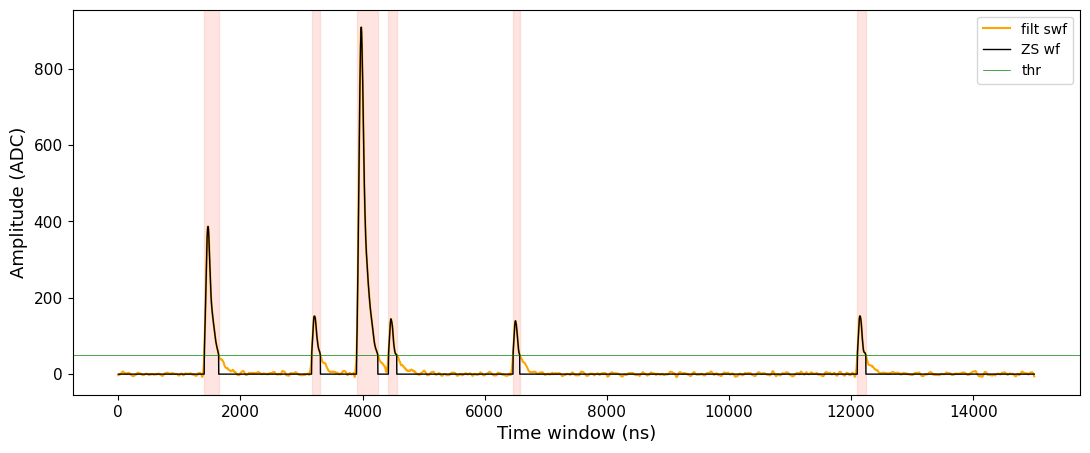

In [36]:
sel_ch  = 10
sel_evt = 0

fswf = sg_filt_trigg_dict   [sel_ch][sel_evt]
zswf = zs_sg_filt_trigg_dict[sel_ch][sel_evt]

sel_idxs     = idx_peaks_ch_trigg_dict          [sel_ch][sel_evt]
sel_heights1 = height_peaks_ch_trigg_dict       [sel_ch][sel_evt]
sel_heights2 = height_peaks_deconv_ch_trigg_dict[sel_ch][sel_evt]
    
plt.figure(figsize=(13, 5))
plt.plot(2*np.arange(len(fswf)), fswf, linewidth=1.5, label='filt swf', color='orange')
plt.plot(2*np.arange(len(zswf)), zswf, linewidth=1.,  label='ZS wf'   , color='k')
plt.axhline(y=thr_ADC, color='green',  linewidth=0.5, label='thr')
for chunk in chunks:
    plt.axvspan(2*chunk[0], 2*chunk[-1], color='salmon', alpha=0.2)
plt.xlabel('Time window (ns)', fontsize=13)
plt.ylabel('Amplitude (ADC)',  fontsize=13)
#plt.xlim(1000, 12000)
plt.legend(fontsize=10)
plt.show()

In [37]:
zswf

array([0., 0., 0., ..., 0., 0., 0.])

6


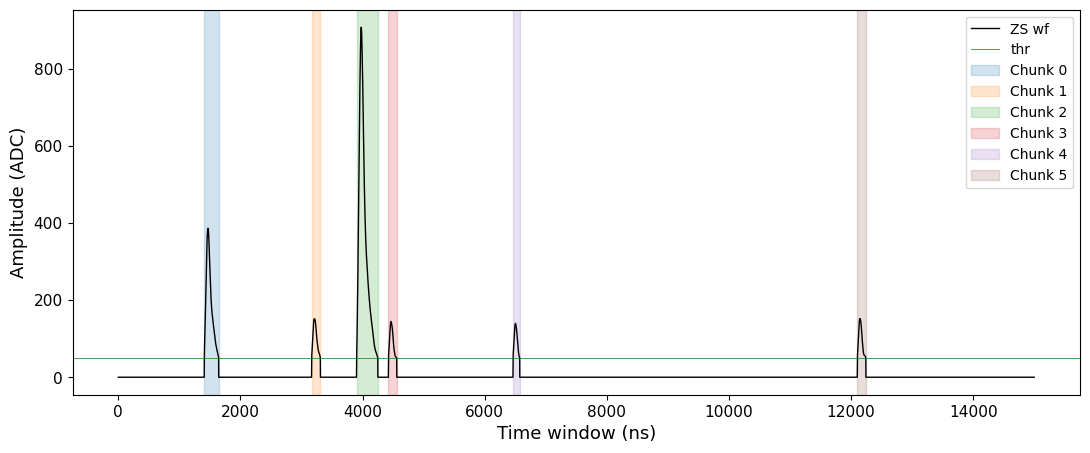

In [38]:
nonzero_indices  = np.nonzero(zswf)[0]
split_indices    = np.split(nonzero_indices, np.where(np.diff(nonzero_indices) > 1)[0] + 1)
chunks           = [zswf[sidx] for sidx in split_indices]

print(len(chunks))
    
plt.figure(figsize=(13, 5))
plt.plot(2*np.arange(len(zswf)), zswf, linewidth=1.,  label='ZS wf'   , color='k')
plt.axhline(y=thr_ADC, color='green',  linewidth=0.5, label='thr')
for i, (chunk, col) in enumerate(zip(split_indices, plt.rcParams['axes.prop_cycle'].by_key()['color'])):
    plt.axvspan(2*chunk[0], 2*chunk[-1], alpha=0.2, color=col, label=f'Chunk {i}')
plt.xlabel('Time window (ns)', fontsize=13)
plt.ylabel('Amplitude (ADC)',  fontsize=13)
#plt.xlim(1000, 12000)
plt.legend(fontsize=10)
plt.show()

In [39]:
split_indices;

In [40]:
def get_time_peak_above_thr(waveform):
    nonzero_indices  = np.nonzero(waveform)[0]
    split_indices    = np.split(nonzero_indices, np.where(np.diff(nonzero_indices) > 1)[0] + 1)
    #chunks          = [waveform[sidx] for sidx in split_indices]
    time_thr_ab_peak = np.array([idx_chunk[0] for idx_chunk in split_indices])
    return time_thr_ab_peak

idx_peaks_ab_thr_ch_dict = {ch: np.array(list(map(get_time_peak_above_thr, zs_sg_filt_swfs_dict[ch])), dtype=object)
                            for ch in normal_chs}

4626 4626
5284 5300


ValueError: x and y must be the same size

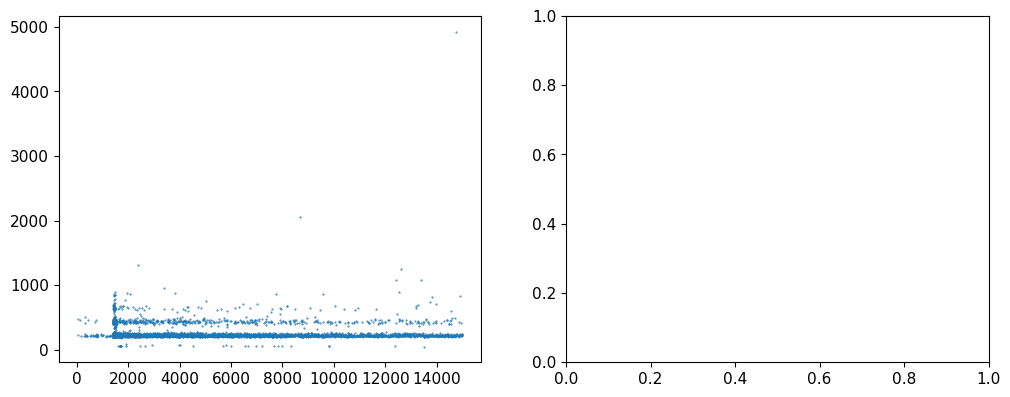

In [41]:
for ch in normal_chs:
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4.5))
    ax0.scatter(2*np.concatenate((idx_peaks_ch_dict[ch])), np.concatenate((height_peaks_ch_dict       [ch])), s=0.2)
    #ax1.scatter(2*np.concatenate((idx_peaks_ch_dict[ch])), np.concatenate((height_peaks_deconv_ch_dict[ch])), s=0.2)
    print(len(idx_peaks_ab_thr_ch_dict[ch]), len(height_peaks_deconv_ch_dict[ch]))
    print(len(np.concatenate((idx_peaks_ab_thr_ch_dict[ch]))), len(np.concatenate((height_peaks_deconv_ch_dict[ch]))))
    ax1.scatter(2*np.concatenate((idx_peaks_ab_thr_ch_dict[ch])), np.concatenate((height_peaks_deconv_ch_dict[ch])), s=0.2)
    ax0.set_ylim(0, 1500)
    ax0.set_title(f'Channel {ch}')
    ax0.set_xlabel('Time window (ns)', fontsize=13)
    ax0.set_ylabel('Amplitude (ADC)',  fontsize=13)
    ax1.set_ylim(0, 1500)
    ax1.set_title(f'Channel {ch}, deconv peaks')
    ax1.set_xlabel('Time window (ns)', fontsize=13)
    ax1.set_ylabel('Amplitude (ADC)',  fontsize=13)
    plt.tight_layout()
    plt.show()

In [44]:
sel_ch = 0
for i,(evt,x,y,z) in enumerate(zip(filt_evts_dict[ch], idx_peaks_ab_thr_ch_dict[sel_ch], height_peaks_deconv_ch_dict[sel_ch], idx_peaks_ch_dict[0])):
    if len(x) != len(y) or len(x) != len(z):
        print(i, evt, len(x),len(y),len(z))

70 352 3 2 2
112 568 1 2 2
162 784 2 1 1
190 947 1 2 2
269 1359 2 1 1
463 2347 2 1 1
503 2540 3 2 2
710 3426 3 2 2
787 3802 1 2 2
869 4202 2 1 1
882 4263 2 1 1
889 4308 1 2 2
895 4357 4 3 3
925 4518 2 1 1
1075 5310 2 1 1
1130 5608 2 3 3
1164 5767 2 1 1
1225 6091 1 2 2
1244 6163 1 2 2
1301 6485 2 1 1
1319 6579 1 2 2
1351 6722 1 2 2
1394 6894 1 2 2
1395 6895 2 1 1
1422 7054 2 1 1
1436 7143 1 2 2
1657 8313 1 2 2
1769 8874 2 1 1
1772 8881 1 2 2
1857 9339 1 2 2
1950 9765 1 2 2
1958 9809 1 2 2
1976 9908 3 4 4
2021 10166 2 1 1
2033 10255 1 2 2
2111 10567 1 2 2
2124 10636 3 2 2
2300 11528 2 1 1
2320 11662 1 2 2
2346 11809 2 3 3
2421 12197 1 2 2
2470 12448 2 3 3
2491 12560 2 1 1
2525 12741 1 2 2
2554 12891 1 2 2
2590 13037 1 2 2
2718 13723 1 2 2
3055 15368 1 2 2
3103 15624 1 2 2
3106 15649 3 4 4
3558 17995 1 2 2
3859 19561 1 2 2
3875 19629 1 2 2
3915 19810 1 2 2
3948 20017 2 1 1
3956 20053 1 0 0
4271 21804 2 1 1
4340 22183 2 3 3
4374 22346 1 2 2
4471 22860 1 2 2
4478 22896 2 1 1
4479 22913 1 2 

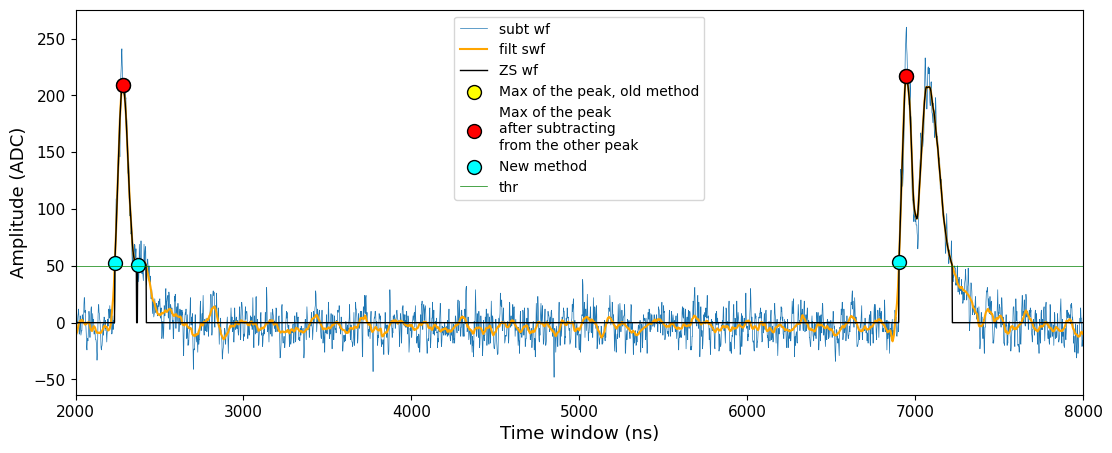

In [45]:
sel_ch  = 0
sel_evt = 70

sel_wf = subt_wfs_dict       [sel_ch][sel_evt]
fswf   = sg_filt_swfs_dict   [sel_ch][sel_evt]
zswf   = zs_sg_filt_swfs_dict[sel_ch][sel_evt]

sel_idxs     = idx_peaks_ch_dict          [sel_ch][sel_evt]
sel_heights1 = height_peaks_ch_dict       [sel_ch][sel_evt]
sel_heights2 = height_peaks_deconv_ch_dict[sel_ch][sel_evt]
sel_idxs2    = idx_peaks_ab_thr_ch_dict   [sel_ch][sel_evt]
    
plt.figure(figsize=(13, 5))
plt.plot(2*np.arange(len(sel_wf)), sel_wf, linewidth=0.5, label='subt wf')
plt.plot(2*np.arange(len(fswf)), fswf, linewidth=1.5, label='filt swf', color='orange')
plt.plot(2*np.arange(len(zswf)), zswf, linewidth=1.,  label='ZS wf'   , color='k')

plt.scatter(2*sel_idxs,  sel_heights1,    color='yellow', edgecolors='black', marker='o', s=100, zorder=2, label=f'Max of the peak, old method')
plt.scatter(2*sel_idxs,  sel_heights2,    color='red',    edgecolors='black', marker='o', s=100, zorder=2, label=f'Max of the peak \nafter subtracting \nfrom the other peak')
plt.scatter(2*sel_idxs2, zswf[sel_idxs2], color='cyan',   edgecolors='black', marker='o', s=100, zorder=2, label=f'New method')

plt.axhline(y=thr_ADC, color='green', linewidth=0.5, label='thr')
plt.xlabel('Time window (ns)', fontsize=13)
plt.ylabel('Amplitude (ADC)',  fontsize=13)
plt.xlim(2000, 8000)
plt.legend(fontsize=10)
plt.show()

## Try to understand:

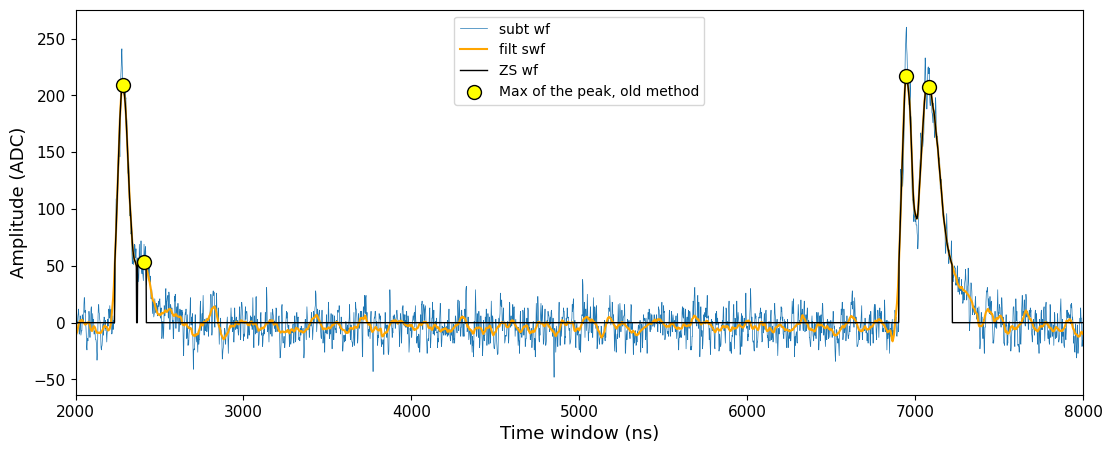

In [46]:
sel_ch  = 0
sel_evt = 70

sel_wf = subt_wfs_dict       [sel_ch][sel_evt]
fswf   = sg_filt_swfs_dict   [sel_ch][sel_evt]
zswf   = zs_sg_filt_swfs_dict[sel_ch][sel_evt]

idx_peaks_evt    = pf.get_peaks_peakutils(zswf, thres=thr_ADC, min_dist=50, thres_abs=True)
height_peaks_evt = pf.peak_height(zswf, idx_peaks_evt)

plt.figure(figsize=(13, 5))
plt.plot(2*np.arange(len(sel_wf)), sel_wf, linewidth=0.5, label='subt wf')
plt.plot(2*np.arange(len(fswf)), fswf, linewidth=1.5, label='filt swf', color='orange')
plt.plot(2*np.arange(len(zswf)), zswf, linewidth=1.,  label='ZS wf'   , color='k')
plt.scatter(2*idx_peaks_evt, height_peaks_evt, color='yellow', edgecolors='black', marker='o', s=100, zorder=2, label=f'Max of the peak, old method')

plt.xlabel('Time window (ns)', fontsize=13)
plt.ylabel('Amplitude (ADC)',  fontsize=13)
plt.xlim(2000, 8000)
plt.legend(fontsize=10)
plt.show()

In [47]:
nonzero_indices  = np.nonzero(zswf)[0]
split_indices    = np.split(nonzero_indices, np.where(np.diff(nonzero_indices) > 1)[0] + 1)
chunks           = [zswf[sidx] for sidx in split_indices]
chunks

[array([ 52.081585,  59.25255 ,  66.94649 ,  74.74745 ,  82.98615 ,
         91.38745 , 100.0624  , 109.06068 , 117.898315, 126.88572 ,
        136.00427 , 144.72615 , 153.43846 , 162.30875 , 170.90178 ,
        178.3997  , 184.43956 , 189.99039 , 195.31938 , 200.50677 ,
        203.97134 , 206.48827 , 208.19572 , 208.9548  , 208.55981 ,
        207.04102 , 205.41794 , 203.87596 , 201.81538 , 199.56836 ,
        196.59639 , 192.85294 , 188.25572 , 183.02014 , 177.32904 ,
        170.97202 , 164.53009 , 157.63924 , 150.716   , 143.86707 ,
        136.49515 , 128.93895 , 121.80673 , 115.52509 , 109.85899 ,
        104.830574, 100.30318 ,  95.29596 ,  89.76779 ,  84.414665,
         79.72947 ,  75.32827 ,  70.877785,  66.79409 ,  63.510433,
         60.95351 ,  59.02798 ,  57.0888  ,  55.9088  ,  54.817356,
         54.198174,  53.582836,  52.24327 ,  51.212837,  50.581104],
       dtype=float32),
 array([50.50279 , 50.886635, 51.491444, 51.935047, 52.12173 , 52.027405,
        52.34418 ,

In [48]:
def peak_height_deconv(zs_waveform, peaks, heights):
    for idx_peak in range(len(peaks)-1):
        zswf_sel = zs_waveform[peaks[idx_peak]:peaks[idx_peak+1]]
        if np.any(zswf_sel == 0):
            continue
        else:
            heights[idx_peak+1] -= np.min(zswf_sel)
    return heights

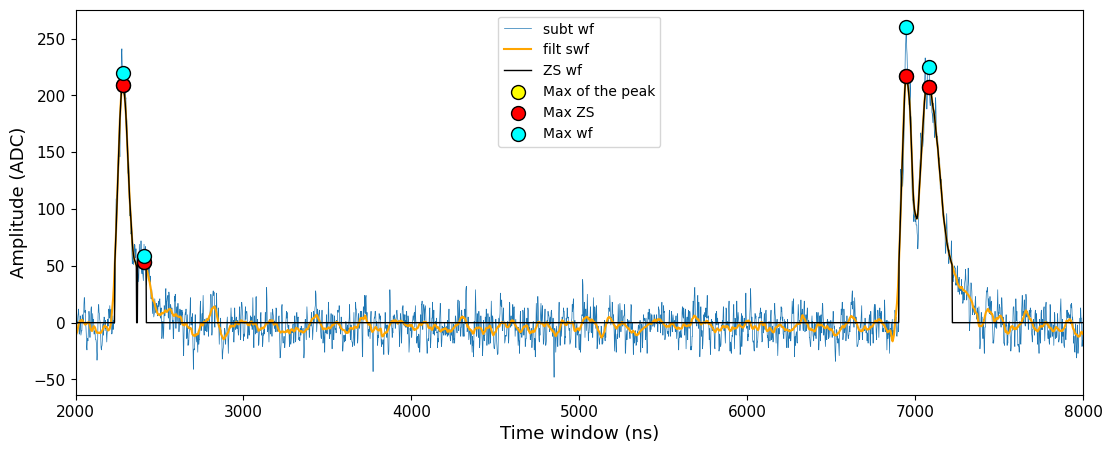

In [49]:
plt.figure(figsize=(13, 5))
plt.plot(2*np.arange(len(sel_wf)), sel_wf, linewidth=0.5, label='subt wf')
plt.plot(2*np.arange(len(fswf)), fswf, linewidth=1.5, label='filt swf', color='orange')
plt.plot(2*np.arange(len(zswf)), zswf, linewidth=1.,  label='ZS wf'   , color='k')
plt.scatter(2*idx_peaks_evt, height_peaks_evt,      color='yellow', edgecolors='black', marker='o', s=100, zorder=2, label=f'Max of the peak')
plt.scatter(2*idx_peaks_evt, zswf[idx_peaks_evt],   color='red',  edgecolors='black', marker='o', s=100, zorder=2, label=f'Max ZS')
plt.scatter(2*idx_peaks_evt, sel_wf[idx_peaks_evt], color='cyan', edgecolors='black', marker='o', s=100, zorder=2, label=f'Max wf')

plt.xlabel('Time window (ns)', fontsize=13)
plt.ylabel('Amplitude (ADC)',  fontsize=13)
plt.xlim(2000, 8000)
plt.legend(fontsize=10)
plt.show()

In [50]:
pos_test = np.ones(len(idx_peaks_evt))
for i, peak in enumerate(idx_peaks_evt):
    if i==0:
        pos_test[i] = np.where((zswf[:peak]>0))[0][0]
    else:
        zeros_in_range = np.where((zswf[idx_peaks_evt[i-1]:peak]==0))[0]
        if len(zeros_in_range)==0:
            pos_test[i] = np.argmin(zswf[idx_peaks_evt[i-1]:peak])+1+idx_peaks_evt[i-1]
        else:
            pos_test[i] = idx_peaks_evt[i-1]+zeros_in_range[-1]+1

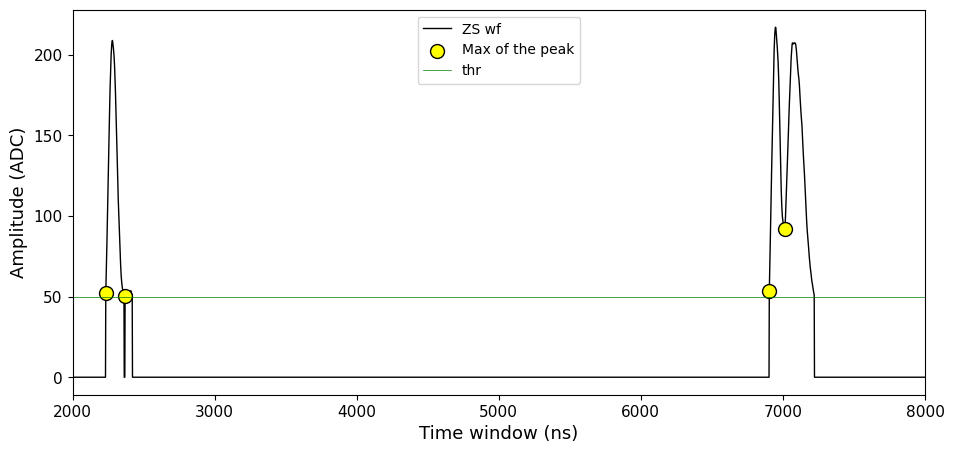

In [51]:
plt.figure(figsize=(11, 5))
plt.plot(2*np.arange(len(zswf)), zswf, linewidth=1.,  label='ZS wf'   , color='k')
plt.scatter(2*pos_test, zswf[pos_test.astype(int)], color='yellow', edgecolors='black', marker='o', s=100, zorder=2, label=f'Max of the peak')
plt.axhline(y=thr_ADC, color='green', linewidth=0.5, label='thr')
plt.xlabel('Time window (ns)', fontsize=13)
plt.ylabel('Amplitude (ADC)',  fontsize=13)
plt.xlim(2000, 8000)
plt.legend(fontsize=10)
plt.show()

In [52]:
def get_values_thr_from_zswf(waveform, idx_peaks):
    
    ## The wfs should be zeros except for the peaks
    vals_thr = np.ones(len(idx_peaks))
    for i, peak in enumerate(idx_peaks):
        if i==0:
            if len(np.where(waveform[:peak]>0)[0])==0:
                vals_thr[i] = peak
            else:
                vals_thr[i] = np.where(waveform[:peak]>0)[0][0]
        else:
            zeros_in_range = np.where(waveform[idx_peaks[i-1]:peak]==0)[0]
            if len(zeros_in_range)==0:
                vals_thr[i] = np.argmin(waveform[idx_peaks[i-1]:peak]) + idx_peaks[i-1]
            else:
                vals_thr[i] = idx_peaks[i-1] + zeros_in_range[-1] + 1
    
    return vals_thr

In [53]:
idx_peaks_thr_ch_trigg_dict = {ch: np.array([get_values_thr_from_zswf(wf, idx_peaks_ch_trigg_dict[ch][i])
                                            for i,wf in enumerate(zs_sg_filt_trigg_dict[ch])], dtype=object)
                              for ch in trigger_chs}

In [54]:
len(idx_peaks_thr_ch_trigg_dict[9]), len(idx_peaks_ch_trigg_dict[9])

(23655, 23655)

In [ ]:
height_peaks_ch_dict = {ch: np.array([wf[idx_peaks_ch_dict[ch][i]] if len(idx_peaks_ch_dict[ch][i])!=0 else np.array([0])
                                            for i, wf in enumerate(subt_wfs_dict[ch])], dtype=object)
                              for ch in normal_chs}

In [68]:
for ch in normal_chs:
    for i, wf in enumerate(subt_wfs_dict2[ch]):
        if len(wf)==0:
            print('eeeeyyy')

## Test file from Jan

In [91]:
filename3 = f"/Users/romoluque_c/LEGEND/BACON/datatest/run-01_18_2024-file_4.root"
infile3   = uproot.open(filename3)
RawTree3  = infile3['RawTree']

## Parameters
max_smpl_bsl        = 650
std_bsl_thr         = 15
sg_filter_window    = 50
sg_filter_polyorder = 3
thr_ADC             = 50 #ths for the noise suppression and peak finder after SG filter
min_dist            = 50 #min distance between peaks for peakutils

normal_chs  = range(9)
trigger_chs = [9, 10, 11]


#### CHANNELS FROM 0 TO 8:
## In the normal SiPMs, a filter is performed to remove the baseline evts
filt_wfs_dict3 = {ch: np.array([(evt, wf)
                               for evt, wf in enumerate(pf.wfs_from_rawtree(RawTree3, ch)) if np.std(wf) > std_bsl_thr], dtype=object)
                 for ch in normal_chs}

#filt_evts      = np.unique(np.concatenate(np.array([filt_wfs_dict[ch].T[0] for ch in normal_chs])))
filt_evts_dict3 = {ch: filt_wfs_dict3[ch].T[0]
                  if len(filt_wfs_dict3[ch])!=0 else []
                  for ch in normal_chs}

## Baseline subtraction
subt_wfs_dict3 = {ch: np.array([pf.subtract_baseline(fwf,
                                          mode=True,
                                          wf_range_bsl=(0, max_smpl_bsl))
                                          for _, fwf in filt_wfs_dict3[ch]])
                 if len(filt_wfs_dict3[ch])!=0 else []
                 for ch in normal_chs}

## Apply the Savitzky-Golay filter to smooth the wf
sg_filt_swfs_dict3 = {ch: savgol_filter(subt_wfs_dict3[ch],
                                       window_length=sg_filter_window,
                                       polyorder=sg_filter_polyorder)
                     if len(subt_wfs_dict3[ch]) != 0 else []
                     for ch in normal_chs}

## Noise suppression
zs_sg_filt_swfs_dict3 = {ch: pf.noise_suppression(sg_filt_swfs_dict3[ch],
                                                 threshold=thr_ADC)
                        if len(sg_filt_swfs_dict3[ch]) != 0 else []
                        for ch in normal_chs}

## Get peaks above thr_ADC
partial_get_peaks_peakutils = partial(pf.get_peaks_peakutils, thres=thr_ADC, min_dist=min_dist, thres_abs=True)
idx_peaks_ch_dict3 = {ch: np.array(list(map(partial_get_peaks_peakutils, zs_sg_filt_swfs_dict3[ch])), dtype=object)
                     for ch in normal_chs}

idx_peaks_thr_ch_dict3 = {ch: np.array([get_values_thr_from_zswf(wf, idx_peaks_ch_dict3[ch][i])
                                      for i,wf in enumerate(zs_sg_filt_swfs_dict3[ch])], dtype=object)
                         for ch in normal_chs}

height_peaks_ch_dict3 = {ch: np.array([wf[idx_peaks_ch_dict3[ch][i]] if len(idx_peaks_ch_dict3[ch][i])!=0 else np.array([])
                                            for i, wf in enumerate(subt_wfs_dict3[ch])], dtype=object)
                              for ch in normal_chs}

height_peaks_sg_ch_dict3 = {ch: np.array([pf.peak_height(wf, idx_peaks_ch_dict3[ch][i])
                                      for i,wf in enumerate(zs_sg_filt_swfs_dict3[ch])], dtype=object)
                        for ch in normal_chs}

height_peaks_deconv_ch_dict3 = {ch: np.array([pf.peak_height_deconv(wf,
                                                                   idx_peaks_ch_dict3   [ch][i],
                                                                   height_peaks_ch_dict3[ch][i].copy())
                               for i, wf in enumerate(zs_sg_filt_swfs_dict3[ch])], dtype=object)
                               for ch in normal_chs}

In [92]:
print(len(np.concatenate(height_peaks_ch_dict3[2])))
print(len(np.concatenate(idx_peaks_ch_dict3[2])))
print(len(np.concatenate(height_peaks_sg_ch_dict3[2])))
print(len(np.concatenate(height_peaks_deconv_ch_dict3[2])))

1359
1359
1359
1359


In [79]:
#height_peaks_ch_dict3 = {ch: np.array([wf[idx_peaks_ch_dict3[ch][i]] if len(idx_peaks_ch_dict3[ch][i])!=0 else np.array([])
#                                            for i, wf in enumerate(subt_wfs_dict3[ch])], dtype=object)
#                              }
for ch in normal_chs:
    for i, wf in enumerate(subt_wfs_dict3[ch]):
        if len(idx_peaks_ch_dict3[ch][i])==0:
            print(ch, i, wf, idx_peaks_ch_dict3[ch][i])

2 157 [-14. -36. -11. ... -11.   0.  25.] []
3 2364 [407. 428. 424. ...  -5.  -7. -25.] []
4 20 [-29. -12.  46. ...  15.  21.  30.] []
6 120 [-17.  -8.  -5. ... 248. 246. 235.] []
7 4535 [411. 399. 386. ... -11.  -1. -14.] []
7 6133 [188. 172. 174. ...  -5. -18. -13.] []
7 7619 [418. 413. 393. ... -16. -11. -11.] []
8 1339 [27. 36.  8. ... -4.  0. -8.] []
8 8280 [257. 253. 255. ...   8.  11.   5.] []


## Test file from Dec

In [69]:
filename2 = f"/Users/romoluque_c/LEGEND/BACON/datatest/run-12_20_2023-file_7.root"
infile2   = uproot.open(filename2)
RawTree2  = infile2['RawTree']

## Parameters
max_smpl_bsl        = 650
std_bsl_thr         = 15
sg_filter_window    = 50
sg_filter_polyorder = 3
thr_ADC             = 50 #ths for the noise suppression and peak finder after SG filter
min_dist            = 50 #min distance between peaks for peakutils

normal_chs  = range(9)
trigger_chs = [9, 10, 11]


#### CHANNELS FROM 0 TO 8:
## In the normal SiPMs, a filter is performed to remove the baseline evts
filt_wfs_dict2 = {ch: np.array([(evt, wf)
                               for evt, wf in enumerate(pf.wfs_from_rawtree(RawTree2, ch)) if np.std(wf) > std_bsl_thr], dtype=object)
                 for ch in normal_chs}

#filt_evts      = np.unique(np.concatenate(np.array([filt_wfs_dict[ch].T[0] for ch in normal_chs])))
filt_evts_dict2 = {ch: filt_wfs_dict2[ch].T[0]
                  if len(filt_wfs_dict2[ch])!=0 else []
                  for ch in normal_chs}

## Baseline subtraction
subt_wfs_dict2 = {ch: np.array([pf.subtract_baseline(fwf,
                                          mode=True,
                                          wf_range_bsl=(0, max_smpl_bsl))
                                          for _, fwf in filt_wfs_dict2[ch]])
                 if len(filt_wfs_dict2[ch])!=0 else []
                 for ch in normal_chs}

## Apply the Savitzky-Golay filter to smooth the wf
sg_filt_swfs_dict2 = {ch: savgol_filter(subt_wfs_dict2[ch],
                                       window_length=sg_filter_window,
                                       polyorder=sg_filter_polyorder)
                     if len(subt_wfs_dict2[ch]) != 0 else []
                     for ch in normal_chs}

## Noise suppression
zs_sg_filt_swfs_dict2 = {ch: pf.noise_suppression(sg_filt_swfs_dict2[ch],
                                                 threshold=thr_ADC)
                        if len(sg_filt_swfs_dict2[ch]) != 0 else []
                        for ch in normal_chs}

## Get peaks above thr_ADC
partial_get_peaks_peakutils = partial(pf.get_peaks_peakutils, thres=thr_ADC, min_dist=min_dist, thres_abs=True)
idx_peaks_ch_dict2 = {ch: np.array(list(map(partial_get_peaks_peakutils, zs_sg_filt_swfs_dict2[ch])), dtype=object)
                     for ch in normal_chs}

idx_peaks_thr_ch_dict2 = {ch: np.array([get_values_thr_from_zswf(wf, idx_peaks_ch_dict2[ch][i])
                                      for i,wf in enumerate(zs_sg_filt_swfs_dict2[ch])], dtype=object)
                         for ch in normal_chs}

height_peaks_ch_dict2 = {ch: np.array([wf[idx_peaks_ch_dict2[ch][i]]
                                      for i,wf in enumerate(subt_wfs_dict2[ch])], dtype=object)
                        for ch in normal_chs}

height_peaks_sg_ch_dict2 = {ch: np.array([pf.peak_height(wf, idx_peaks_ch_dict2[ch][i])
                                      for i,wf in enumerate(zs_sg_filt_swfs_dict2[ch])], dtype=object)
                        for ch in normal_chs}

height_peaks_deconv_ch_dict2 = {ch: np.array([pf.peak_height_deconv(wf,
                                                                   idx_peaks_ch_dict2   [ch][i],
                                                                   height_peaks_ch_dict2[ch][i].copy())
                               for i, wf in enumerate(zs_sg_filt_swfs_dict2[ch])], dtype=object)
                               for ch in normal_chs}


#### TRIGGER SIPMS
## In the deconvolution the baseline is already subtracted from the waveform!!!
trigg_cwfs_dict2 = {ch: np.array([blr.pmt_deconvolver(wf, wf_range_bsl=(0, max_smpl_bsl))
                                 for wf in pf.wfs_from_rawtree(RawTree2, ch)])
                   for ch in trigger_chs}

sg_filt_trigg_dict2 = {ch: savgol_filter(trigg_cwfs_dict2[ch],
                                        window_length=sg_filter_window,
                                        polyorder=sg_filter_polyorder)
                      for ch in trigger_chs}

zs_sg_filt_trigg_dict2 = {ch: pf.noise_suppression(sg_filt_trigg_dict2[ch],
                                                  threshold=thr_ADC)
                         for ch in trigger_chs}

idx_peaks_ch_trigg_dict2 = {ch: np.array(list(map(partial_get_peaks_peakutils, zs_sg_filt_trigg_dict2[ch])), dtype=object)
                           for ch in trigger_chs}

idx_peaks_thr_ch_trigg_dict2 = {ch: np.array([get_values_thr_from_zswf(wf, idx_peaks_ch_trigg_dict2[ch][i])
                                            for i,wf in enumerate(zs_sg_filt_trigg_dict2[ch])], dtype=object)
                               for ch in trigger_chs}

height_peaks_ch_trigg_dict2 = {ch: np.array([wf[idx_peaks_ch_trigg_dict2[ch][i]]
                                            for i,wf in enumerate(trigg_cwfs_dict2[ch])], dtype=object)
                              for ch in trigger_chs}

height_peaks_sg_ch_trigg_dict2 = {ch: np.array([pf.peak_height(wf, idx_peaks_ch_trigg_dict2[ch][i])
                                               for i,wf in enumerate(zs_sg_filt_trigg_dict2[ch])], dtype=object)
                                 for ch in trigger_chs}

height_peaks_deconv_ch_trigg_dict2 = {ch: np.array([pf.peak_height_deconv(wf,
                                                                        idx_peaks_ch_trigg_dict2   [ch][i],
                                                                        height_peaks_ch_trigg_dict2[ch][i].copy())
                                     for i, wf in enumerate(zs_sg_filt_trigg_dict2[ch])], dtype=object)
                                     for ch in trigger_chs}

In [71]:
idx_peaks_thr_ch_trigg_dict2[10][22717], idx_peaks_ch_trigg_dict2[10][22717]

(array([479., 713., 831.]), array([479, 742, 835]))

In [72]:
idx_peaks_ch_trigg_dict2

{9: array([array([758]), array([762, 940]), array([761]), ...,
        array([752, 980]), array([ 743, 1806]), array([750])], dtype=object),
 10: array([array([753]), array([744]), array([742, 840]), ...,
        array([748, 862]), array([ 743,  828, 1851, 1963]),
        array([746, 821, 927])], dtype=object),
 11: array([array([756, 860, 934]), array([746]), array([741, 860]), ...,
        array([753, 925]), array([743, 850]), array([742])], dtype=object)}

In [73]:
for ch in trigger_chs:
    for i,wf in enumerate(zs_sg_filt_trigg_dict2[ch]):
        if i==22717 and ch==10:
            print(ch, i, idx_peaks_ch_trigg_dict2[ch][i], get_values_thr_from_zswf(wf, idx_peaks_ch_trigg_dict2[ch][i]))

10 22717 [479 742 835] [479. 713. 831.]


In [74]:
height_peaks_ch_trigg_dict2 = {ch: np.array([wf[idx_peaks_ch_trigg_dict2[ch][i]]
                                            for i,wf in enumerate(trigg_cwfs_dict2[ch])], dtype=object)
                              for ch in trigger_chs}

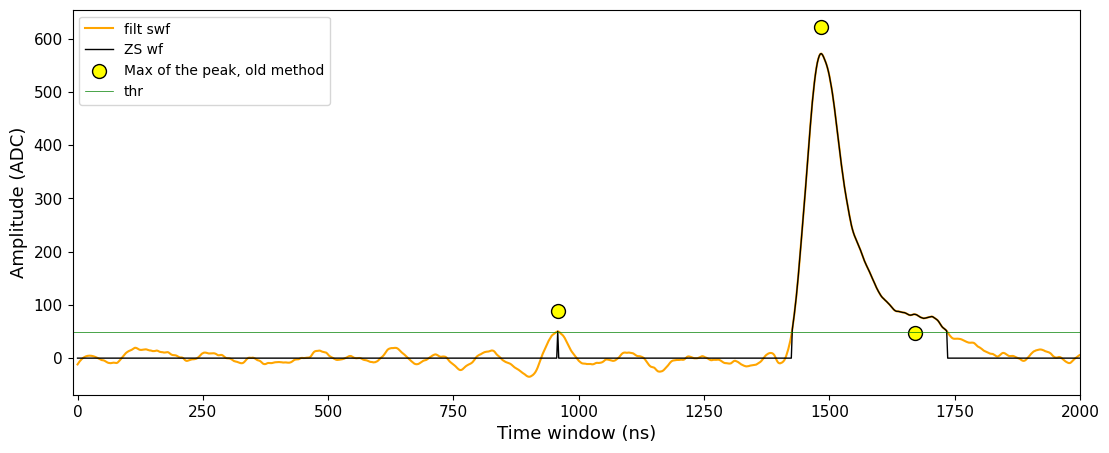

In [75]:
sel_ch  = 10
sel_evt = 22717

sel_wf_trig = trigg_cwfs_dict2      [sel_ch][sel_evt]
fswf_trig   = sg_filt_trigg_dict2   [sel_ch][sel_evt]
zswf_trig   = zs_sg_filt_trigg_dict2[sel_ch][sel_evt]

idx_peaks_evt    = idx_peaks_ch_trigg_dict2   [sel_ch][sel_evt]
height_peaks_evt = height_peaks_ch_trigg_dict2[sel_ch][sel_evt]

plt.figure(figsize=(13, 5))
#plt.plot(2*np.arange(len(sel_wf_trig)), sel_wf_trig, linewidth=0.5, label='subt wf')
plt.plot(2*np.arange(len(fswf_trig)), fswf_trig, linewidth=1.5, label='filt swf', color='orange')
plt.plot(2*np.arange(len(zswf_trig)), zswf_trig, linewidth=1.,  label='ZS wf'   , color='k')
plt.scatter(2*idx_peaks_evt, height_peaks_evt, color='yellow', edgecolors='black', marker='o', s=100, zorder=2, label=f'Max of the peak, old method')

plt.axhline(y=thr_ADC, color='green', linewidth=0.5, label='thr')

plt.xlabel('Time window (ns)', fontsize=13)
plt.ylabel('Amplitude (ADC)',  fontsize=13)
plt.xlim(-10, 2000)
#plt.xlim(1400, 1700)
plt.legend(fontsize=10)
plt.show()